In [1]:
from __future__ import print_function
import rospy
import numpy as np
import math
import tf.transformations as T
import matplotlib.pyplot as plt
import csv
import sys, os
import spatialmath as sm

# from pathlib import Path
from user_perspective_legibility import UserPerspectiveLegibility
from legible_trajectory import LegibleMovement
from image_annotations_3d import ImageAnnotations3D
from geometry_msgs.msg import Pose, Quaternion, Point
from mpl_toolkits.mplot3d import Axes3D
from collections import OrderedDict
from robot_models import *
np.set_printoptions(precision=5, linewidth=2000, threshold=10000, suppress=True)
%matplotlib notebook

In [2]:
def run_simulation(filename: str, learn_rate: float, decay_rate: float, optimization_criteria: str, n_iterations: int,
                   optim_target: str, traj: np.ndarray, n_targets: int, targets: dict, targets_pos: list, n_users: int,
                   user_poses: list, u_ids: list, robot_pose: Pose, horizontal_fov: int, vertical_fov: int,
                   user_defined_ids: list, user_poses_defined: list, regularization: float, use_joints: bool, 
                   robot_model: rtb.DHRobot=None, model_pose: np.ndarray = np.eye(4), plotting=False, write_mode='a',
                   store_mode='all'):
    user1_translation = user_poses_defined[0].position
    user2_translation = user_poses_defined[1].position
    user3_translation = user_poses_defined[2].position
    robot_translation = robot_pose.position

    improved_trajs = OrderedDict()
    trajs_legibility = OrderedDict()
    optim_iteration = 0
    optim_traj = traj.copy()
    prev_optim_traj = traj.copy()
    optim_legibility = 0
    optim_user_legibilities = []
    prev_optim_legibility = 0
    prev_optim_user_legibilities = []
    legible_movement = LegibleMovement(n_targets=n_targets, targets_pos=targets_pos, n_users=n_users, using_ros=False,
                                       user_poses=user_poses, robot_pose=robot_pose, w_field_of_view=horizontal_fov,
                                       h_field_of_view=vertical_fov, orientation_type='euler', u_ids=u_ids,
                                       joint_optim=use_joints, robot_model=robot_model, model_pose=model_pose,
                                       regularizaiton=regularization)

    # Start optimization process
    for i in range(n_iterations):
        print('Iteration: ' + str(i + 1))
        improved_traj = legible_movement.improveTrajectory(robot_target=optim_target, trajectory=optim_traj,
                                                           optimization_criteria=optimization_criteria,
                                                           learn_rate=learn_rate)
        if use_joints:
            world_improved_traj = transform_world(
                forward_kinematics_irb4600(robot_model, improved_traj), robot_pose)
        else:
            world_improved_traj = improved_traj
        impossible_traj = np.isnan(improved_traj).any()
        improved_legibility = 0
        users = legible_movement.get_users()
        transformed_legibility = []

        # Verify if improved trajectory is possible for all users
        for user in u_ids:
            traj_leg = users[user].trajectoryLegibility(targets_pos, world_improved_traj, has_transform=True)

            impossible_traj = np.isnan(traj_leg)
            if impossible_traj:
                break

            improved_legibility += traj_leg
            transformed_legibility += [traj_leg]
            if i == 0 or (i < 1001 and (i + 1) % 100 == 0) or (i + 1) % 1000 == 0:
                print('User: %s\tLegibility: %.5f' % (user, traj_leg))

        # In case of a possible trajectory update optimization results
        if not impossible_traj:
            improved_legibility = improved_legibility / float(len(u_ids))
            print('Legibility improvement: %.9f' % (improved_legibility - optim_legibility))
            if improved_legibility >= optim_legibility and (abs(improved_legibility - optim_legibility) > 1e-13):
                prev_optim_traj = optim_traj
                prev_optim_legibility = optim_legibility
                prev_optim_user_legibilities = optim_user_legibilities
                optim_traj = improved_traj
                optim_legibility = improved_legibility
                optim_user_legibilities = transformed_legibility
                optim_iteration += 1

                if i == 0 or (i < 1001 and (i + 1) % 100 == 0) or (i + 1) % 1000 == 0:
                    print('Average Legibility: %.5f' % improved_legibility)
                    improved_trajs[str(i + 1)] = improved_traj
                    trajs_legibility[str(i + 1)] = [transformed_legibility, improved_legibility]

            elif abs(improved_legibility - optim_legibility) > 1e-13:
                learn_rate /= 10.0
                if learn_rate > 1e-10:
                    continue
                else:
                    break

            else:
                break

        # In case of an impossible trajectory, break optimization loop
        else:

            learn_rate /= 10.0
            if learn_rate > 1e-10:
                i -= 1
                continue
            else:
                optim_traj = prev_optim_traj
                optim_legibility = prev_optim_legibility
                optim_user_legibilities = prev_optim_user_legibilities

                print('Improved trajectory unfeasable. Stopping optimization process')
                break

        if (i + 1) % 100 == 0:
            print(1 / (1 + decay_rate * i))
            learn_rate = 1 / (1 + decay_rate * i) * learn_rate

    # Plot of optimized and original trajectories
    if plotting:
        if use_joints:
            optim_plot_traj = transform_world(forward_kinematics_irb4600(robot_model, optim_traj), robot_pose)
            orig_plot_traj = transform_world(forward_kinematics_irb4600(robot_model, traj), robot_pose)
        else:
            optim_plot_traj = optim_traj
            orig_plot_traj = traj
        fig1 = plt.figure('Optimized vs Original Trajectory')
        plt.clf()
        ax = fig1.gca(projection='3d')
        # ax.plot(np.array([user1_translation[0]]), np.array([user1_translation[1]]), np.array([user1_translation[2]]),
        #         color='red', marker='2', markersize=15, label='User1')
        # ax.plot(np.array([user2_translation[0]]), np.array([user2_translation[1]]), np.array([user2_translation[2]]),
        #         color='green', marker='2', markersize=15, label='User2')
        # ax.plot(np.array([user3_translation[0]]), np.array([user3_translation[1]]), np.array([user3_translation[2]]),
        #         color='brown', marker='2', markersize=15, label='User3')
        ax.plot(np.array([targets['A'][0]]), np.array([targets['A'][1]]), np.array([targets['A'][2]]),
                color='darkorange', marker='D', markersize=10)
        ax.plot(np.array([targets['B'][0]]), np.array([targets['B'][1]]), np.array([targets['B'][2]]),
                color='darkorange', marker='D', markersize=10)
        ax.plot(np.array([targets['C'][0]]), np.array([targets['C'][1]]), np.array([targets['C'][2]]),
                color='darkorange', marker='D', markersize=10)
        # ax.plot(np.array([robot_translation[0]]), np.array([robot_translation[1]]), np.array([robot_translation[2]]),
        #         color='blue', marker='o', markersize=10, label='Robot')
        ax.plot(np.array([optim_plot_traj[0, 0]]), np.array([optim_plot_traj[0, 1]]), np.array([optim_plot_traj[0, 2]]),
                color='black', marker='*', markersize=10, label='Start')
        ax.plot(np.array([optim_plot_traj[-1, 0]]), np.array([optim_plot_traj[-1, 1]]),
                np.array([optim_plot_traj[-1, 2]]),
                color='gold', marker='*', markersize=10, label='Goal')
        ax.plot(optim_plot_traj[:, 0], optim_plot_traj[:, 1], optim_plot_traj[:, 2], 'green', markersize=10, marker='.',
                label='Optimized Trajectory')
        ax.plot(orig_plot_traj[:, 0], orig_plot_traj[:, 1], orig_plot_traj[:, 2], 'blue', markersize=10, marker='.',
                label='Original Trajectory')
        plt.legend(loc='best')
        fig1.show()
        x = input()

    # Output optimization results
    print('----------------------------------------')
    print('|--------------------------------------|')
    print('|                                      |')
    print('|         Optimization Results         |')
    print('|                                      |')
    print('|--------------------------------------|')
    print('----------------------------------------')
    print('Optim Trajctory:')
    if use_joints:
        print(transform_world(forward_kinematics_irb4600(robot_model, optim_traj), robot_pose))
        print(optim_traj)
    else:
        print(optim_traj)
    print('------------------------------------')
    print('Optim Trajectory Legibility: %.5f' % optim_legibility)
    print('------------------------------------')
    print('Optim User Legibilities:')
    if n_users > 1:
        for i in range(n_users):
            print('%s legibility: %.5f' % (u_ids[i].capitalize(), optim_user_legibilities[i]))
    print('------------------------------------')
    print('\n')

    # Legibility values for all users - For evaluation purposes
    print('-------------------------------------------------')
    print('|-----------------------------------------------|')
    print('|                                               |')
    print('|         Results For All Defined Users         |')
    print('|                                               |')
    print('|-----------------------------------------------|')
    print('-------------------------------------------------')
    eval_legibility = LegibleMovement(n_targets=3, targets_pos=targets_pos, n_users=len(user_defined_ids),
                                      using_ros=False, user_poses=user_poses_defined, robot_pose=robot_pose,
                                      w_field_of_view=horizontal_fov, h_field_of_view=vertical_fov,
                                      orientation_type='euler', u_ids=user_defined_ids,
                                      joint_optim=use_joints, robot_model=robot_model, regularizaiton=regularization)
    eval_users = eval_legibility.get_users()
    eval_leg_avg = 0
    optim_legs = []
    print('------------------------')
    print('Legibility for each user')
    if use_joints:
        world_optim_traj = transform_world(forward_kinematics_irb4600(robot_model, optim_traj), robot_pose)
    else:
        world_optim_traj = optim_traj
    for user in user_defined_ids:
        eval_users[user].updateTarget(optim_target)
        user_leg = eval_users[user].trajectoryLegibility(targets=targets_pos, orig_trajectory=world_optim_traj,
                                                         has_transform=True)
        user_leg = 0 if np.isnan(user_leg) else user_leg
        print('%s legibility: %.5f' % (user.capitalize(), user_leg))
        eval_leg_avg += user_leg
        optim_legs += [user_leg]
    optim_avg_leg = eval_leg_avg / len(user_defined_ids)
    print('-------------------------')
    print('Average Legibility: %.5f' % optim_avg_leg)
    print('-------------------------')
    print('\n\n\n')

    return improved_trajs, trajs_legibility
    # Storing trajectories and legibilities in file
    #improved_trajs[str(optim_iteration)] = optim_traj
    #trajs_legibility[str(optim_iteration)] = [optim_legs, optim_avg_leg]
    #print('--------------------------------')
    #print('| Storing Trajectories to file |')
    #print('--------------------------------')
    #write_file = open(filename, write_mode)
    #writer = csv.writer(write_file)
    #writer.writerow(['Iteration', 'Trajectory', 'Legibility'])
    #if store_mode.find('all') != -1:
    #    for key in improved_trajs.keys():
    #        writer.writerow([key, improved_trajs[key], trajs_legibility[key]])
    #elif store_mode.find('optim') != -1:
    #    key = str(optim_iteration)
    #    writer.writerow([key, improved_trajs[key], trajs_legibility[key]])
    #else:
    #    print('[SIMULATION ERROR] Invalid storing mode given. No results saved to file.')
    #write_file.close()

In [3]:
def transform_world(trajectory: np.ndarray, pose: Pose) -> np.ndarray:
    orientation = Quaternion(pose.orientation[0], pose.orientation[1],
                             pose.orientation[2], pose.orientation[3])
    position = Point(pose.position[0], pose.position[1], pose.position[2])

    alpha, beta, gamma = T.euler_from_quaternion((orientation.x, orientation.y, orientation.z, orientation.w))
    transformation = T.euler_matrix(alpha, beta, gamma)

    transformation[0, 3] = position.x
    transformation[1, 3] = position.y
    transformation[2, 3] = position.z

    transformed_trajectory = []
    for i in range(len(trajectory)):
        projected_point = transformation.dot(np.concatenate((trajectory[i], 1), axis=None))[:-1]
        transformed_trajectory += [projected_point]

    return np.array(transformed_trajectory)

In [4]:
def forward_kinematics(robot_model: rtb.DHRobot, joint_trajectory: np.ndarray) -> np.ndarray:

    cartesian_trajectory = []

    for i in range(len(joint_trajectory)):

        fk_result = robot_model.fkine(joint_trajectory[i])
        cartesian_trajectory += [fk_result.t * 1000]        # need the *1000 to convert from meters to milimeters

    return np.array(cartesian_trajectory)

In [5]:
def forward_kinematics_irb4600(robot_model: rtb.DHRobot, joint_trajectory: np.ndarray) -> np.ndarray:

    cartesian_trajectory = []
    transformation = np.array([[0, 0, 1, 0],
                               [1, 0, 0, 0],
                               [0, 1, 0, 0],
                               [0, 0, 0, 1]])

    for i in range(len(joint_trajectory)):

        fk_result = robot_model.fkine(joint_trajectory[i])  # get the end-effector in relation to robot's base

        # transform position to robot space
        robot_fk = np.linalg.inv(transformation).dot(np.concatenate((fk_result.t, 1), axis=None))[:-1]
        cartesian_trajectory += [robot_fk * 1000]           # need the *1000 to convert from meters to milimeters

    return np.array(cartesian_trajectory)

In [6]:
def prepare_trajectory(trajectory: np.ndarray, robot_pose: Pose, robot_model: rtb.DHRobot) -> np.ndarray:

    robot_orientation = Quaternion(robot_pose.orientation[0], robot_pose.orientation[1],
                                   robot_pose.orientation[2], robot_pose.orientation[3])
    robot_position = Point(robot_pose.position[0], robot_pose.position[1], robot_pose.position[2])

    robot_euler = T.euler_from_quaternion((robot_orientation.x, robot_orientation.y,
                                           robot_orientation.z, robot_orientation.w))

    robot_transformation = T.euler_matrix(robot_euler[0], robot_euler[1], robot_euler[2])

    robot_transformation[0, 3] = robot_position.x
    robot_transformation[1, 3] = robot_position.y
    robot_transformation[2, 3] = robot_position.z
    robot_transformation = np.linalg.inv(robot_transformation)

    transformation = np.array([[0, 0, 1, 0],
                               [1, 0, 0, 0],
                               [0, 1, 0, 0],
                               [0, 0, 0, 1]])
    
    transformed_trajectory = []
    for i in range(len(trajectory)):
        projected_point = robot_transformation.dot(np.concatenate((trajectory[i], 1), axis=None))/1000
        projected_point = transformation.dot(projected_point)[:-1]
        ik_result, fail, err = robot_model.ikine(sm.SE3(projected_point[0], projected_point[1], projected_point[2]))
        transformed_trajectory += [ik_result]

    return np.array(transformed_trajectory)

In [48]:
file_path = os.path.dirname(sys.argv[0])
full_path = os.path.abspath(file_path)
image_dir = full_path + '/images'

# Configuration 1
user1_rot = T.quaternion_from_euler(ai=math.radians(180), aj=math.radians(260), ak=math.radians(0), axes='rzxy')
user2_rot = T.quaternion_from_euler(ai=math.radians(90), aj=math.radians(260), ak=math.radians(0), axes='rzxy')
user3_rot = T.quaternion_from_euler(ai=math.radians(270), aj=math.radians(260), ak=math.radians(0), axes='rzxy')
# Configuration 2
# user1_rot = T.quaternion_from_euler(ai=math.radians(0), aj=math.radians(65), ak=math.radians(0), axes='rzxy')
# user2_rot = T.quaternion_from_euler(ai=math.radians(300), aj=math.radians(65), ak=math.radians(0), axes='rzxy')
# user3_rot = T.quaternion_from_euler(ai=math.radians(60), aj=math.radians(65), ak=math.radians(0), axes='rzxy')
# Configuration 3
# user1_rot = T.quaternion_from_euler(ai=math.radians(0), aj=math.radians(70), ak=math.radians(0), axes='rzxy')
# user2_rot = T.quaternion_from_euler(ai=math.radians(-30), aj=math.radians(70), ak=math.radians(0), axes='rzxy')
# user3_rot = T.quaternion_from_euler(ai=math.radians(30), aj=math.radians(70), ak=math.radians(0), axes='rzxy')
# Configuration 4
# user1_rot = T.quaternion_from_euler(ai=math.radians(0), aj=math.radians(75), ak=math.radians(0), axes='rzxy')
# user2_rot = T.quaternion_from_euler(ai=math.radians(-50), aj=math.radians(75), ak=math.radians(0), axes='rzxy')
# user3_rot = T.quaternion_from_euler(ai=math.radians(50), aj=math.radians(75), ak=math.radians(0), axes='rzxy')
# Configuration 5
# user1_rot = T.quaternion_from_euler(ai=math.radians(315), aj=math.radians(65), ak=math.radians(0), axes='rzxy')
# user2_rot = T.quaternion_from_euler(ai=math.radians(295), aj=math.radians(65), ak=math.radians(0), axes='rzxy')
# user3_rot = T.quaternion_from_euler(ai=math.radians(270), aj=math.radians(65), ak=math.radians(0), axes='rzxy')
# Configuration 6
# user1_rot = T.quaternion_from_euler(ai=math.radians(0), aj=math.radians(75), ak=math.radians(0), axes='rzxy')
# user2_rot = T.quaternion_from_euler(ai=math.radians(330), aj=math.radians(75), ak=math.radians(0), axes='rzxy')
# user3_rot = T.quaternion_from_euler(ai=math.radians(315), aj=math.radians(75), ak=math.radians(0), axes='rzxy')
# Configuration 7
# user1_rot = T.quaternion_from_euler(ai=math.radians(0), aj=math.radians(75), ak=math.radians(0), axes='rzxy')
# user2_rot = T.quaternion_from_euler(ai=math.radians(-80), aj=math.radians(75), ak=math.radians(0), axes='rzxy')
# user3_rot = T.quaternion_from_euler(ai=math.radians(80), aj=math.radians(75), ak=math.radians(0), axes='rzxy')
# Configuration 8
# user1_rot = T.quaternion_from_euler(ai=math.radians(0), aj=math.radians(65), ak=math.radians(0), axes='rzxy')
# user2_rot = T.quaternion_from_euler(ai=math.radians(270), aj=math.radians(65), ak=math.radians(0), axes='rzxy')
# user3_rot = T.quaternion_from_euler(ai=math.radians(90), aj=math.radians(65), ak=math.radians(0), axes='rzxy')
# Robot rotation
robot_rot = T.quaternion_from_euler(ai=math.radians(0), aj=math.radians(90), ak=math.radians(0), axes='rzxy')

# Configuration 1-4, 7-8
user1_translation = (1500.0, 1000.0, 1000.0)
user2_translation = (500.0, 1500.0, 1000.0)
user3_translation = (2500, 1500.0, 1000.0)
# Configuration 5
# user1_translation = (500.0, 1000.0, 1700.0)
# user2_translation = (500.0, 1500.0, 1700.0)
# user3_translation = (500.0, 2000.0, 1700.0)
# Configuration 6
# user1_translation = (1500.0, 1000.0, 1700.0)
# user2_translation = (1000.0, 1200.0, 1700.0)
# user3_translation = (500.0, 1400.0, 1700.0)
# Configuration 7
# Robot Position
robot_translation = (1500.0, 3000.0, 250.0)

# Poses
robot_pose = Pose(position=robot_translation, orientation=robot_rot)
user1_pose = Pose(position=user1_translation, orientation=user1_rot)
user2_pose = Pose(position=user2_translation, orientation=user2_rot)
user3_pose = Pose(position=user3_translation, orientation=user3_rot)

# Configuration 1-3
# targets = {'A': np.array([1800.0, 1300.0, 250.0]), 'B': np.array([1500.0, 1300.0, 250.0]),
#            'C': np.array([1200.0, 1300.0, 250.0])}
targets = {'A': np.array([1200.0, 1500.0, 450.0]), 'B': np.array([1500.0, 1500.0, 450.0]),
           'C': np.array([1800.0, 1500.0, 450.0])}
# targets = {'A': np.array([1800.0, 1700.0, 250.0]), 'B': np.array([1500.0, 1700.0, 250.0]),
#            'C': np.array([1200.0, 1700.0, 250.0])}
# Configuration 4
# targets = {'A': np.array([1250.0, 1600.0, 250.0]), 'B': np.array([1750.0, 1600.0, 250.0]),
#            'C': np.array([1500.0, 1300.0, 250.0])}
# Configuration 5
# targets = {'A': np.array([1200.0, 1500.0, 250.0]), 'B': np.array([1500.0, 1500.0, 250.0]),
#            'C': np.array([1800.0, 1500.0, 250.0])}
# Configuration 6
# targets = {'A': np.array([1250.0, 1700.0, 250.0]), 'B': np.array([1500.0, 1500.0, 250.0]),
#            'C': np.array([1800.0, 1300.0, 250.0])}
# Configuration 7
# targets = {'A': np.array([1250.0, 1600.0, 250.0]), 'B': np.array([1500.0, 1800.0, 250.0]),
#            'C': np.array([1750.0, 1600.0, 250.0])}
# Configuration 8
# targets = {'A': np.array([1500.0, 1200.0, 250.0]), 'B': np.array([1500.0, 1800.0, 250.0]),
#            'C': np.array([1500.0, 1500.0, 250.0])}
movement_start = np.array([1500., 2000., 450.])

# Parameterization
optimization_criteria = 'avg'
# optimization_criteria = 'minmax'
vertical_fov = 55
horizontal_fov = 120
n_iterations = 10000
learn_rate = 0.5
decay_rate = 0.0001
regularization = 0.35
n_users = 3
n_targets = len(targets)
optim_target = 'A'
user_poses = [user1_pose, user2_pose, user3_pose]
# user_poses = [user2_pose]
u_ids = ['user1', 'user2', 'user3']
# u_ids = ['user2']
filename = "../data/3_users_multiple_trajs.csv"
# filename = "../data/1_user_conf_7_u2_c.csv"
targets_pos = list(targets.values())

# Variables and definitions for performance evaluation
user_poses_defined = [user1_pose, user2_pose, user3_pose]
user_defined_ids = ['user1', 'user2', 'user3']

# Trajectory Creation
n_points = 20
traj_x = np.linspace(movement_start[0], targets[optim_target][0], num=n_points)[:, None]
traj_y = np.linspace(movement_start[1], targets[optim_target][1], num=n_points)[:, None]
traj_z = np.linspace(movement_start[2], targets[optim_target][2], num=n_points)[:, None]
# offset_modulator = 300 * np.sin(np.linspace(0, np.pi, num=n_points))[:, None]
# Trajectory Creation Simulation
# traj_x = np.linspace(robot_translation[0], targets[optim_target][0], num=n_points)[:, None]
# traj_y = np.linspace(targets[optim_target][1], targets[optim_target][1], num=n_points)[:, None]
# traj_z = np.linspace(robot_translation[2], targets[optim_target][2], num=n_points)[:, None]

base_traj = np.hstack((traj_x, traj_y, traj_z))
# h_mod_traj = np.hstack((traj_x, traj_y, traj_z + offset_modulator))
# r_mod_traj = np.hstack((traj_x - offset_modulator, traj_y, traj_z))
# l_mod_traj = np.hstack((traj_x + offset_modulator, traj_y, traj_z))
# hr_mod_traj = np.hstack((traj_x - offset_modulator, traj_y, traj_z + offset_modulator))
# hl_mod_traj = np.hstack((traj_x + offset_modulator, traj_y, traj_z + offset_modulator))
# r_spring_mod_traj = np.hstack((traj_x - offset_modulator, traj_y - offset_modulator, traj_z))
# l_spring_mod_traj = np.hstack((traj_x + offset_modulator, traj_y - offset_modulator, traj_z))
trajectories_sequence = [base_traj]
# trajectories_sequence = [base_traj, h_mod_traj, r_mod_traj, l_mod_traj, hr_mod_traj, hl_mod_traj,
#                         r_spring_mod_traj, l_spring_mod_traj]

In [ ]:
user1 = UserPerspectiveLegibility(using_ros=False, orientation_type='euler', user_id='user1',
                                  user_pose=user1_pose, robot_pose=robot_pose)
user2 = UserPerspectiveLegibility(using_ros=False, orientation_type='euler', user_id='user2',
                                  user_pose=user2_pose, robot_pose=robot_pose)
user3 = UserPerspectiveLegibility(using_ros=False, orientation_type='euler', user_id='user3',
                                  user_pose=user3_pose, robot_pose=robot_pose)
robot = UserPerspectiveLegibility(using_ros=False, orientation_type='euler', user_id='robot',
                                  user_pose=robot_pose, robot_pose=robot_pose)

user1_traj = user1.transformTrajectory(base_traj, viewport=False)
user2_traj = user2.transformTrajectory(base_traj, viewport=False)
user3_traj = user3.transformTrajectory(base_traj, viewport=False)
robot_traj = robot.transformTrajectory(base_traj, viewport=False)

# user1_transformed_u1 = np.array([0, 0, 0])
# user1_transformed_u2 = user2.transformTrajectory(np.array([user1_translation]), viewport=False)[0]
# user1_transformed_u3 = user3.transformTrajectory(np.array([user1_translation]), viewport=False)[0]
# user2_transformed_u1 = user1.transformTrajectory(np.array([user2_translation]), viewport=False)[0]
# user2_transformed_u2 = np.array([0, 0, 0])
# user2_transformed_u3 = user3.transformTrajectory(np.array([user2_translation]), viewport=False)[0]
# user3_transformed_u1 = user1.transformTrajectory(np.array([user3_translation]), viewport=False)[0]
# user3_transformed_u2 = user2.transformTrajectory(np.array([user3_translation]), viewport=False)[0]
# user3_transformed_u3 = np.array([0, 0, 0])
# robot_transformed_u1 = user1.transformTrajectory(np.array([robot_translation]), viewport=False)[0]
# robot_transformed_u2 = user2.transformTrajectory(np.array([robot_translation]), viewport=False)[0]
# robot_transformed_u3 = user3.transformTrajectory(np.array([robot_translation]), viewport=False)[0]
# targets_u1 = {'A': user1.transformTrajectory(np.array([targets['A']]), viewport=False)[0],
# 			'B': user1.transformTrajectory(np.array([targets['B']]), viewport=False)[0],
# 			'C': user1.transformTrajectory(np.array([targets['C']]), viewport=False)[0]}
# targets_u2 = {'A': user2.transformTrajectory(np.array([targets['A']]), viewport=False)[0],
# 			 'B': user2.transformTrajectory(np.array([targets['B']]), viewport=False)[0],
# 			 'C': user2.transformTrajectory(np.array([targets['C']]), viewport=False)[0]}
# targets_u3 = {'A': user3.transformTrajectory(np.array([targets['A']]), viewport=False)[0],
# 			 'B': user3.transformTrajectory(np.array([targets['B']]), viewport=False)[0],
# 			 'C': user3.transformTrajectory(np.array([targets['C']]), viewport=False)[0]}

print('Original Trajectory')
print(base_traj)
print('User 1 transformed trajectory')
print(user1_traj)
print('User 2 transformed trajectory')
print(user2_traj)
print('User 3 transformed trajectory')
print(user3_traj)
print('Robot transformed trajectory')
print(robot_traj)
#print(transform_world(robot_traj, robot_pose))

# fig = plt.figure('Original Trajectory')
# ax = fig.add_subplot(111, projection=Axes3D.name)
# ax.plot(base_traj[:, 0], base_traj[:, 1], base_traj[:, 2], 'black', label='Trajectory', marker='.', linestyle="None")
# ax.plot(np.array([user1_translation[0]]), np.array([user1_translation[1]]), np.array([user1_translation[2]]),
#         color='red', marker='2', markersize=15, label='User1')
# ax.plot(np.array([user2_translation[0]]), np.array([user2_translation[1]]), np.array([user2_translation[2]]),
#         color='green', marker='2', markersize=15, label='User2')
# ax.plot(np.array([user3_translation[0]]), np.array([user3_translation[1]]), np.array([user3_translation[2]]),
#         color='brown', marker='2', markersize=15, label='User3')
# ax.plot(np.array([robot_translation[0]]), np.array([robot_translation[1]]), np.array([robot_translation[2]]),
#         color='blue', marker='2', markersize=15, label='Robot')
# ax.plot(np.array([targets['A'][0]]), np.array([targets['A'][1]]), np.array([targets['A'][2]]),
#         color='darkorange', marker='D', markersize=10)
# ax.plot(np.array([targets['B'][0]]), np.array([targets['B'][1]]), np.array([targets['B'][2]]),
#         color='darkorange', marker='D', markersize=10)
# ax.plot(np.array([targets['C'][0]]), np.array([targets['C'][1]]), np.array([targets['C'][2]]),
#         color='darkorange', marker='D', markersize=10)
# plt.legend(loc='best')
# ax.view_init(azim=180, elev=-10)
# fig.show()

# fig = plt.figure('Trajectories Visual')
# ax = fig.add_subplot(111, projection=Axes3D.name)
# ax.plot(base_traj[:, 0], base_traj[:, 1], base_traj[:, 2], 'black', label='Base', marker='.',
# 		linestyle="None")
# ax.plot(h_mod_traj[:, 0], h_mod_traj[:, 1], h_mod_traj[:, 2], 'blue', label='Height', marker='.',
# 		linestyle="None")
# ax.plot(r_mod_traj[:, 0], r_mod_traj[:, 1], r_mod_traj[:, 2], 'green', label='Right', marker='.',
# 		linestyle="None")
# ax.plot(l_mod_traj[:, 0], l_mod_traj[:, 1], l_mod_traj[:, 2], 'cyan', label='Left', marker='.',
# 		linestyle="None")
# ax.plot(hr_mod_traj[:, 0], hr_mod_traj[:, 1], hr_mod_traj[:, 2], 'red', label='Right Height', marker='.',
# 		linestyle="None")
# ax.plot(hl_mod_traj[:, 0], hl_mod_traj[:, 1], hl_mod_traj[:, 2], 'orange', label='Left Height', marker='.',
# 		linestyle="None")
# ax.plot(r_spring_mod_traj[:, 0], r_spring_mod_traj[:, 1], r_spring_mod_traj[:, 2], 'brown', label='Right Spring',
# 		marker='.', linestyle="None")
# ax.plot(l_spring_mod_traj[:, 0], l_spring_mod_traj[:, 1], l_spring_mod_traj[:, 2], 'pink', label='Left Spring',
# 		marker='.', linestyle="None")
# ax.plot(np.array([user1_translation[0]]), np.array([user1_translation[1]]), np.array([user1_translation[2]]),
#         color='red', marker='2', markersize=15, label='User1')
# ax.plot(np.array([user2_translation[0]]), np.array([user2_translation[1]]), np.array([user2_translation[2]]),
#         color='green', marker='2', markersize=15, label='User2')
# ax.plot(np.array([user3_translation[0]]), np.array([user3_translation[1]]), np.array([user3_translation[2]]),
#         color='brown', marker='2', markersize=15, label='User3')
# ax.plot(np.array([robot_translation[0]]), np.array([robot_translation[1]]), np.array([robot_translation[2]]),
#         color='blue', marker='2', markersize=15, label='Robot')
# ax.plot(np.array([targets['A'][0]]), np.array([targets['A'][1]]), np.array([targets['A'][2]]),
#         color='darkorange', marker='D', markersize=10)
# ax.plot(np.array([targets['B'][0]]), np.array([targets['B'][1]]), np.array([targets['B'][2]]),
#         color='darkorange', marker='D', markersize=10)
# ax.plot(np.array([targets['C'][0]]), np.array([targets['C'][1]]), np.array([targets['C'][2]]),
#         color='darkorange', marker='D', markersize=10)
# plt.legend(loc='best')
# fig.show()

# fig = plt.figure('Trajectories Visual User')
# ax = fig.add_subplot(111, projection=Axes3D.name)
# ax.plot(user2_traj[:, 0], user2_traj[:, 1], user2_traj[:, 2], 'black', label='Base')
# ax.plot(np.array([user1_transformed_u2[0]]), np.array([user1_transformed_u2[1]]), np.array([user1_transformed_u2[2]]),
#         color='red', marker='$User_1$', markersize=15, label='User1')
# ax.plot(np.array([user2_transformed_u2[0]]), np.array([user2_transformed_u2[1]]), np.array([user2_transformed_u2[2]]),
#         color='green', marker='2', markersize=15, label='User2')
# ax.plot(np.array([user3_transformed_u2[0]]), np.array([user3_transformed_u2[1]]), np.array([user3_transformed_u2[2]]),
#         color='brown', marker='$User_3$', markersize=15, label='User3')
# ax.plot(np.array([robot_transformed_u2[0]]), np.array([robot_transformed_u2[1]]), np.array([robot_transformed_u2[2]]),
#         color='blue', marker='o', markersize=7, label='Robot')
# ax.plot(np.array([targets_u2['A'][0]]), np.array([targets_u2['A'][1]]), np.array([targets_u2['A'][2]]),
#         color='darkorange', marker='D', markersize=10)
# ax.plot(np.array([targets_u2['B'][0]]), np.array([targets_u2['B'][1]]), np.array([targets_u2['B'][2]]),
#         color='darkorange', marker='D', markersize=10)
# ax.plot(np.array([targets_u2['C'][0]]), np.array([targets_u2['C'][1]]), np.array([targets_u2['C'][2]]),
#         color='darkorange', marker='D', markersize=10)
# plt.legend(loc='best')
# ax.view_init(azim=-90, elev=120)
#fig.show()

#fig = plt.figure('Trajectories Visual User')
#ax = fig.add_subplot(111, projection=Axes3D.name)
#ax.plot(user1_traj[:, 0], user1_traj[:, 1], user1_traj[:, 2], 'orange', label='U1')
#ax.plot(user2_traj[:, 0], user2_traj[:, 1], user2_traj[:, 2], 'black', label='U2')
#ax.plot(user3_traj[:, 0], user3_traj[:, 1], user3_traj[:, 2], 'blue', label='U3')
#plt.legend(loc='best')
#fig.show()


# x = input()

In [49]:
# Run simulation
n_trajectories = 1
robot_model = IRB4600()
use_joints = True
model_pose = np.array([[0, 0, 1, 0],
                       [1, 0, 0, 0],
                       [0, 1, 0, 0],
                       [0, 0, 0, 1]])
optimization_criteria = 'avg'
for i in range(n_trajectories):
    print('Initial Trajectory')
    if use_joints:
        traj = prepare_trajectory(trajectories_sequence[i], robot_pose, robot_model)
    else:
        traj = trajectories_sequence[i]
    joint_avg_trajs, joint_avg_legs = run_simulation(filename, learn_rate, decay_rate, optimization_criteria, 
                                             n_iterations, optim_target, traj, n_targets, targets, targets_pos, 
                                             n_users, user_poses, u_ids, robot_pose, horizontal_fov,
                                             vertical_fov, user_defined_ids, user_poses_defined, regularization,
                                             use_joints=use_joints, robot_model=robot_model, model_pose=model_pose, 
                                             store_mode='optim', plotting=False)

Initial Trajectory
Iteration: 1
User: user1	Legibility: 0.45167
User: user2	Legibility: 0.51083
User: user3	Legibility: 0.48886
Legibility improvement: 0.483786164
Average Legibility: 0.48379
Iteration: 2
Legibility improvement: 0.000139626
Iteration: 3
Legibility improvement: 0.000140003
Iteration: 4
Legibility improvement: 0.000140380
Iteration: 5
Legibility improvement: 0.000140758
Iteration: 6
Legibility improvement: 0.000141135
Iteration: 7
Legibility improvement: 0.000141512
Iteration: 8
Legibility improvement: 0.000141888
Iteration: 9
Legibility improvement: 0.000142265
Iteration: 10
Legibility improvement: 0.000142642
Iteration: 11
Legibility improvement: 0.000143018
Iteration: 12
Legibility improvement: 0.000143394
Iteration: 13
Legibility improvement: 0.000143770
Iteration: 14
Legibility improvement: 0.000144146
Iteration: 15
Legibility improvement: 0.000144522
Iteration: 16
Legibility improvement: 0.000144898
Iteration: 17
Legibility improvement: 0.000145274
Iteration: 18
Le

Legibility improvement: 0.000196444
Iteration: 159
Legibility improvement: 0.000196833
Iteration: 160
Legibility improvement: 0.000197223
Iteration: 161
Legibility improvement: 0.000197614
Iteration: 162
Legibility improvement: 0.000198005
Iteration: 163
Legibility improvement: 0.000198397
Iteration: 164
Legibility improvement: 0.000198790
Iteration: 165
Legibility improvement: 0.000199183
Iteration: 166
Legibility improvement: 0.000199577
Iteration: 167
Legibility improvement: 0.000199971
Iteration: 168
Legibility improvement: 0.000200366
Iteration: 169
Legibility improvement: 0.000200762
Iteration: 170
Legibility improvement: 0.000201158
Iteration: 171
Legibility improvement: 0.000201555
Iteration: 172
Legibility improvement: 0.000201952
Iteration: 173
Legibility improvement: 0.000202351
Iteration: 174
Legibility improvement: 0.000202750
Iteration: 175
Legibility improvement: 0.000203149
Iteration: 176
Legibility improvement: 0.000203550
Iteration: 177
Legibility improvement: 0.00020

Legibility improvement: 0.000255368
Iteration: 315
Legibility improvement: 0.000255899
Iteration: 316
Legibility improvement: 0.000256431
Iteration: 317
Legibility improvement: 0.000256966
Iteration: 318
Legibility improvement: 0.000257502
Iteration: 319
Legibility improvement: 0.000258039
Iteration: 320
Legibility improvement: 0.000258579
Iteration: 321
Legibility improvement: 0.000259120
Iteration: 322
Legibility improvement: 0.000259663
Iteration: 323
Legibility improvement: 0.000260208
Iteration: 324
Legibility improvement: 0.000260755
Iteration: 325
Legibility improvement: 0.000261303
Iteration: 326
Legibility improvement: 0.000261854
Iteration: 327
Legibility improvement: 0.000262406
Iteration: 328
Legibility improvement: 0.000262960
Iteration: 329
Legibility improvement: 0.000263515
Iteration: 330
Legibility improvement: 0.000264073
Iteration: 331
Legibility improvement: 0.000264632
Iteration: 332
Legibility improvement: 0.000265194
Iteration: 333
Legibility improvement: 0.00026

Legibility improvement: 0.000345694
Iteration: 473
Legibility improvement: 0.000346415
Iteration: 474
Legibility improvement: 0.000347137
Iteration: 475
Legibility improvement: 0.000347858
Iteration: 476
Legibility improvement: 0.000348580
Iteration: 477
Legibility improvement: 0.000349301
Iteration: 478
Legibility improvement: 0.000350023
Iteration: 479
Legibility improvement: 0.000350745
Iteration: 480
Legibility improvement: 0.000351466
Iteration: 481
Legibility improvement: 0.000352188
Iteration: 482
Legibility improvement: 0.000352909
Iteration: 483
Legibility improvement: 0.000353631
Iteration: 484
Legibility improvement: 0.000354352
Iteration: 485
Legibility improvement: 0.000355073
Iteration: 486
Legibility improvement: 0.000355793
Iteration: 487
Legibility improvement: 0.000356514
Iteration: 488
Legibility improvement: 0.000357233
Iteration: 489
Legibility improvement: 0.000357953
Iteration: 490
Legibility improvement: 0.000358672
Iteration: 491
Legibility improvement: 0.00035

Legibility improvement: 0.000381444
Iteration: 629
Legibility improvement: 0.000381507
Iteration: 630
Legibility improvement: 0.000381564
Iteration: 631
Legibility improvement: 0.000381613
Iteration: 632
Legibility improvement: 0.000381656
Iteration: 633
Legibility improvement: 0.000381691
Iteration: 634
Legibility improvement: 0.000381720
Iteration: 635
Legibility improvement: 0.000381742
Iteration: 636
Legibility improvement: 0.000381757
Iteration: 637
Legibility improvement: 0.000381765
Iteration: 638
Legibility improvement: 0.000381766
Iteration: 639
Legibility improvement: 0.000381759
Iteration: 640
Legibility improvement: 0.000381746
Iteration: 641
Legibility improvement: 0.000381726
Iteration: 642
Legibility improvement: 0.000381698
Iteration: 643
Legibility improvement: 0.000381664
Iteration: 644
Legibility improvement: 0.000381622
Iteration: 645
Legibility improvement: 0.000381573
Iteration: 646
Legibility improvement: 0.000381518
Iteration: 647
Legibility improvement: 0.00038

Legibility improvement: 0.000296241
Iteration: 787
Legibility improvement: 0.000295567
Iteration: 788
Legibility improvement: 0.000294892
Iteration: 789
Legibility improvement: 0.000294215
Iteration: 790
Legibility improvement: 0.000293537
Iteration: 791
Legibility improvement: 0.000292857
Iteration: 792
Legibility improvement: 0.000292177
Iteration: 793
Legibility improvement: 0.000291495
Iteration: 794
Legibility improvement: 0.000290811
Iteration: 795
Legibility improvement: 0.000290127
Iteration: 796
Legibility improvement: 0.000289441
Iteration: 797
Legibility improvement: 0.000288755
Iteration: 798
Legibility improvement: 0.000288067
Iteration: 799
Legibility improvement: 0.000287378
Iteration: 800
User: user1	Legibility: 0.62223
User: user2	Legibility: 0.74935
User: user3	Legibility: 0.75844
Legibility improvement: 0.000286689
Average Legibility: 0.71000
0.9260116677470135
Iteration: 801
Legibility improvement: 0.000264864
Iteration: 802
Legibility improvement: 0.000264271
Itera

Legibility improvement: 0.000170398
Iteration: 943
Legibility improvement: 0.000169966
Iteration: 944
Legibility improvement: 0.000169534
Iteration: 945
Legibility improvement: 0.000169104
Iteration: 946
Legibility improvement: 0.000168675
Iteration: 947
Legibility improvement: 0.000168246
Iteration: 948
Legibility improvement: 0.000167819
Iteration: 949
Legibility improvement: 0.000167392
Iteration: 950
Legibility improvement: 0.000166967
Iteration: 951
Legibility improvement: 0.000166542
Iteration: 952
Legibility improvement: 0.000166118
Iteration: 953
Legibility improvement: 0.000165696
Iteration: 954
Legibility improvement: 0.000165274
Iteration: 955
Legibility improvement: 0.000164854
Iteration: 956
Legibility improvement: 0.000164434
Iteration: 957
Legibility improvement: 0.000164015
Iteration: 958
Legibility improvement: 0.000163598
Iteration: 959
Legibility improvement: 0.000163181
Iteration: 960
Legibility improvement: 0.000162765
Iteration: 961
Legibility improvement: 0.00016

Legibility improvement: 0.000106679
Iteration: 1099
Legibility improvement: 0.000106439
Iteration: 1100
Legibility improvement: 0.000106199
0.9009820704567978
Iteration: 1101
Legibility improvement: 0.000095477
Iteration: 1102
Legibility improvement: 0.000095283
Iteration: 1103
Legibility improvement: 0.000095090
Iteration: 1104
Legibility improvement: 0.000094897
Iteration: 1105
Legibility improvement: 0.000094705
Iteration: 1106
Legibility improvement: 0.000094513
Iteration: 1107
Legibility improvement: 0.000094321
Iteration: 1108
Legibility improvement: 0.000094130
Iteration: 1109
Legibility improvement: 0.000093940
Iteration: 1110
Legibility improvement: 0.000093750
Iteration: 1111
Legibility improvement: 0.000093561
Iteration: 1112
Legibility improvement: 0.000093372
Iteration: 1113
Legibility improvement: 0.000093183
Iteration: 1114
Legibility improvement: 0.000092995
Iteration: 1115
Legibility improvement: 0.000092807
Iteration: 1116
Legibility improvement: 0.000092620
Iteration

Legibility improvement: 0.000063772
Iteration: 1256
Legibility improvement: 0.000063666
Iteration: 1257
Legibility improvement: 0.000063559
Iteration: 1258
Legibility improvement: 0.000063453
Iteration: 1259
Legibility improvement: 0.000063347
Iteration: 1260
Legibility improvement: 0.000063241
Iteration: 1261
Legibility improvement: 0.000063135
Iteration: 1262
Legibility improvement: 0.000063030
Iteration: 1263
Legibility improvement: 0.000062925
Iteration: 1264
Legibility improvement: 0.000062820
Iteration: 1265
Legibility improvement: 0.000062716
Iteration: 1266
Legibility improvement: 0.000062611
Iteration: 1267
Legibility improvement: 0.000062507
Iteration: 1268
Legibility improvement: 0.000062403
Iteration: 1269
Legibility improvement: 0.000062300
Iteration: 1270
Legibility improvement: 0.000062196
Iteration: 1271
Legibility improvement: 0.000062093
Iteration: 1272
Legibility improvement: 0.000061990
Iteration: 1273
Legibility improvement: 0.000061888
Iteration: 1274
Legibility i

Legibility improvement: 0.000039415
Iteration: 1413
Legibility improvement: 0.000039369
Iteration: 1414
Legibility improvement: 0.000039323
Iteration: 1415
Legibility improvement: 0.000039277
Iteration: 1416
Legibility improvement: 0.000039231
Iteration: 1417
Legibility improvement: 0.000039185
Iteration: 1418
Legibility improvement: 0.000039140
Iteration: 1419
Legibility improvement: 0.000039094
Iteration: 1420
Legibility improvement: 0.000039049
Iteration: 1421
Legibility improvement: 0.000039004
Iteration: 1422
Legibility improvement: 0.000038958
Iteration: 1423
Legibility improvement: 0.000038913
Iteration: 1424
Legibility improvement: 0.000038868
Iteration: 1425
Legibility improvement: 0.000038823
Iteration: 1426
Legibility improvement: 0.000038778
Iteration: 1427
Legibility improvement: 0.000038733
Iteration: 1428
Legibility improvement: 0.000038688
Iteration: 1429
Legibility improvement: 0.000038644
Iteration: 1430
Legibility improvement: 0.000038599
Iteration: 1431
Legibility i

Legibility improvement: 0.000029106
Iteration: 1571
Legibility improvement: 0.000029080
Iteration: 1572
Legibility improvement: 0.000029054
Iteration: 1573
Legibility improvement: 0.000029029
Iteration: 1574
Legibility improvement: 0.000029003
Iteration: 1575
Legibility improvement: 0.000028978
Iteration: 1576
Legibility improvement: 0.000028952
Iteration: 1577
Legibility improvement: 0.000028927
Iteration: 1578
Legibility improvement: 0.000028901
Iteration: 1579
Legibility improvement: 0.000028876
Iteration: 1580
Legibility improvement: 0.000028851
Iteration: 1581
Legibility improvement: 0.000028825
Iteration: 1582
Legibility improvement: 0.000028800
Iteration: 1583
Legibility improvement: 0.000028775
Iteration: 1584
Legibility improvement: 0.000028750
Iteration: 1585
Legibility improvement: 0.000028725
Iteration: 1586
Legibility improvement: 0.000028700
Iteration: 1587
Legibility improvement: 0.000028675
Iteration: 1588
Legibility improvement: 0.000028650
Iteration: 1589
Legibility i

Legibility improvement: 0.000019198
Iteration: 1728
Legibility improvement: 0.000019187
Iteration: 1729
Legibility improvement: 0.000019177
Iteration: 1730
Legibility improvement: 0.000019167
Iteration: 1731
Legibility improvement: 0.000019156
Iteration: 1732
Legibility improvement: 0.000019146
Iteration: 1733
Legibility improvement: 0.000019136
Iteration: 1734
Legibility improvement: 0.000019126
Iteration: 1735
Legibility improvement: 0.000019115
Iteration: 1736
Legibility improvement: 0.000019105
Iteration: 1737
Legibility improvement: 0.000019095
Iteration: 1738
Legibility improvement: 0.000019085
Iteration: 1739
Legibility improvement: 0.000019075
Iteration: 1740
Legibility improvement: 0.000019064
Iteration: 1741
Legibility improvement: 0.000019054
Iteration: 1742
Legibility improvement: 0.000019044
Iteration: 1743
Legibility improvement: 0.000019034
Iteration: 1744
Legibility improvement: 0.000019024
Iteration: 1745
Legibility improvement: 0.000019014
Iteration: 1746
Legibility i

Legibility improvement: 0.000015168
Iteration: 1886
Legibility improvement: 0.000015163
Iteration: 1887
Legibility improvement: 0.000015157
Iteration: 1888
Legibility improvement: 0.000015152
Iteration: 1889
Legibility improvement: 0.000015146
Iteration: 1890
Legibility improvement: 0.000015141
Iteration: 1891
Legibility improvement: 0.000015136
Iteration: 1892
Legibility improvement: 0.000015130
Iteration: 1893
Legibility improvement: 0.000015125
Iteration: 1894
Legibility improvement: 0.000015120
Iteration: 1895
Legibility improvement: 0.000015115
Iteration: 1896
Legibility improvement: 0.000015109
Iteration: 1897
Legibility improvement: 0.000015104
Iteration: 1898
Legibility improvement: 0.000015099
Iteration: 1899
Legibility improvement: 0.000015094
Iteration: 1900
Legibility improvement: 0.000015088
0.8404067568703253
Iteration: 1901
Legibility improvement: 0.000012677
Iteration: 1902
Legibility improvement: 0.000012673
Iteration: 1903
Legibility improvement: 0.000012669
Iteration

Legibility improvement: 0.000010216
Iteration: 2041
Legibility improvement: 0.000010214
Iteration: 2042
Legibility improvement: 0.000010212
Iteration: 2043
Legibility improvement: 0.000010210
Iteration: 2044
Legibility improvement: 0.000010208
Iteration: 2045
Legibility improvement: 0.000010207
Iteration: 2046
Legibility improvement: 0.000010205
Iteration: 2047
Legibility improvement: 0.000010203
Iteration: 2048
Legibility improvement: 0.000010201
Iteration: 2049
Legibility improvement: 0.000010199
Iteration: 2050
Legibility improvement: 0.000010198
Iteration: 2051
Legibility improvement: 0.000010196
Iteration: 2052
Legibility improvement: 0.000010194
Iteration: 2053
Legibility improvement: 0.000010192
Iteration: 2054
Legibility improvement: 0.000010191
Iteration: 2055
Legibility improvement: 0.000010189
Iteration: 2056
Legibility improvement: 0.000010187
Iteration: 2057
Legibility improvement: 0.000010185
Iteration: 2058
Legibility improvement: 0.000010184
Iteration: 2059
Legibility i

Legibility improvement: 0.000008269
Iteration: 2199
Legibility improvement: 0.000008269
Iteration: 2200
Legibility improvement: 0.000008268
0.8197393228953193
Iteration: 2201
Legibility improvement: 0.000006777
Iteration: 2202
Legibility improvement: 0.000006776
Iteration: 2203
Legibility improvement: 0.000006776
Iteration: 2204
Legibility improvement: 0.000006775
Iteration: 2205
Legibility improvement: 0.000006775
Iteration: 2206
Legibility improvement: 0.000006774
Iteration: 2207
Legibility improvement: 0.000006774
Iteration: 2208
Legibility improvement: 0.000006773
Iteration: 2209
Legibility improvement: 0.000006773
Iteration: 2210
Legibility improvement: 0.000006772
Iteration: 2211
Legibility improvement: 0.000006772
Iteration: 2212
Legibility improvement: 0.000006771
Iteration: 2213
Legibility improvement: 0.000006771
Iteration: 2214
Legibility improvement: 0.000006770
Iteration: 2215
Legibility improvement: 0.000006770
Iteration: 2216
Legibility improvement: 0.000006769
Iteration

Legibility improvement: 0.000005463
Iteration: 2356
Legibility improvement: 0.000005462
Iteration: 2357
Legibility improvement: 0.000005462
Iteration: 2358
Legibility improvement: 0.000005462
Iteration: 2359
Legibility improvement: 0.000005462
Iteration: 2360
Legibility improvement: 0.000005462
Iteration: 2361
Legibility improvement: 0.000005461
Iteration: 2362
Legibility improvement: 0.000005461
Iteration: 2363
Legibility improvement: 0.000005461
Iteration: 2364
Legibility improvement: 0.000005461
Iteration: 2365
Legibility improvement: 0.000005461
Iteration: 2366
Legibility improvement: 0.000005461
Iteration: 2367
Legibility improvement: 0.000005460
Iteration: 2368
Legibility improvement: 0.000005460
Iteration: 2369
Legibility improvement: 0.000005460
Iteration: 2370
Legibility improvement: 0.000005460
Iteration: 2371
Legibility improvement: 0.000005460
Iteration: 2372
Legibility improvement: 0.000005459
Iteration: 2373
Legibility improvement: 0.000005459
Iteration: 2374
Legibility i

Legibility improvement: 0.000003513
Iteration: 2513
Legibility improvement: 0.000003513
Iteration: 2514
Legibility improvement: 0.000003513
Iteration: 2515
Legibility improvement: 0.000003513
Iteration: 2516
Legibility improvement: 0.000003513
Iteration: 2517
Legibility improvement: 0.000003513
Iteration: 2518
Legibility improvement: 0.000003513
Iteration: 2519
Legibility improvement: 0.000003513
Iteration: 2520
Legibility improvement: 0.000003513
Iteration: 2521
Legibility improvement: 0.000003513
Iteration: 2522
Legibility improvement: 0.000003513
Iteration: 2523
Legibility improvement: 0.000003513
Iteration: 2524
Legibility improvement: 0.000003513
Iteration: 2525
Legibility improvement: 0.000003513
Iteration: 2526
Legibility improvement: 0.000003513
Iteration: 2527
Legibility improvement: 0.000003513
Iteration: 2528
Legibility improvement: 0.000003513
Iteration: 2529
Legibility improvement: 0.000003513
Iteration: 2530
Legibility improvement: 0.000003513
Iteration: 2531
Legibility i

Legibility improvement: 0.000002786
Iteration: 2671
Legibility improvement: 0.000002786
Iteration: 2672
Legibility improvement: 0.000002786
Iteration: 2673
Legibility improvement: 0.000002786
Iteration: 2674
Legibility improvement: 0.000002786
Iteration: 2675
Legibility improvement: 0.000002786
Iteration: 2676
Legibility improvement: 0.000002786
Iteration: 2677
Legibility improvement: 0.000002786
Iteration: 2678
Legibility improvement: 0.000002786
Iteration: 2679
Legibility improvement: 0.000002786
Iteration: 2680
Legibility improvement: 0.000002786
Iteration: 2681
Legibility improvement: 0.000002786
Iteration: 2682
Legibility improvement: 0.000002786
Iteration: 2683
Legibility improvement: 0.000002786
Iteration: 2684
Legibility improvement: 0.000002786
Iteration: 2685
Legibility improvement: 0.000002786
Iteration: 2686
Legibility improvement: 0.000002786
Iteration: 2687
Legibility improvement: 0.000002786
Iteration: 2688
Legibility improvement: 0.000002786
Iteration: 2689
Legibility i

Legibility improvement: 0.000001715
Iteration: 2828
Legibility improvement: 0.000001715
Iteration: 2829
Legibility improvement: 0.000001715
Iteration: 2830
Legibility improvement: 0.000001715
Iteration: 2831
Legibility improvement: 0.000001715
Iteration: 2832
Legibility improvement: 0.000001715
Iteration: 2833
Legibility improvement: 0.000001715
Iteration: 2834
Legibility improvement: 0.000001715
Iteration: 2835
Legibility improvement: 0.000001715
Iteration: 2836
Legibility improvement: 0.000001715
Iteration: 2837
Legibility improvement: 0.000001715
Iteration: 2838
Legibility improvement: 0.000001715
Iteration: 2839
Legibility improvement: 0.000001715
Iteration: 2840
Legibility improvement: 0.000001715
Iteration: 2841
Legibility improvement: 0.000001715
Iteration: 2842
Legibility improvement: 0.000001715
Iteration: 2843
Legibility improvement: 0.000001715
Iteration: 2844
Legibility improvement: 0.000001715
Iteration: 2845
Legibility improvement: 0.000001715
Iteration: 2846
Legibility i

Legibility improvement: 0.000001330
Iteration: 2986
Legibility improvement: 0.000001330
Iteration: 2987
Legibility improvement: 0.000001330
Iteration: 2988
Legibility improvement: 0.000001330
Iteration: 2989
Legibility improvement: 0.000001330
Iteration: 2990
Legibility improvement: 0.000001330
Iteration: 2991
Legibility improvement: 0.000001330
Iteration: 2992
Legibility improvement: 0.000001330
Iteration: 2993
Legibility improvement: 0.000001330
Iteration: 2994
Legibility improvement: 0.000001330
Iteration: 2995
Legibility improvement: 0.000001330
Iteration: 2996
Legibility improvement: 0.000001330
Iteration: 2997
Legibility improvement: 0.000001330
Iteration: 2998
Legibility improvement: 0.000001330
Iteration: 2999
Legibility improvement: 0.000001330
Iteration: 3000
User: user1	Legibility: 0.66897
User: user2	Legibility: 0.89964
User: user3	Legibility: 0.83319
Legibility improvement: 0.000001330
Average Legibility: 0.80060
0.7692899453804138
Iteration: 3001
Legibility improvement: 0

Legibility improvement: 0.000000781
Iteration: 3141
Legibility improvement: 0.000000781
Iteration: 3142
Legibility improvement: 0.000000781
Iteration: 3143
Legibility improvement: 0.000000781
Iteration: 3144
Legibility improvement: 0.000000781
Iteration: 3145
Legibility improvement: 0.000000781
Iteration: 3146
Legibility improvement: 0.000000781
Iteration: 3147
Legibility improvement: 0.000000781
Iteration: 3148
Legibility improvement: 0.000000781
Iteration: 3149
Legibility improvement: 0.000000781
Iteration: 3150
Legibility improvement: 0.000000781
Iteration: 3151
Legibility improvement: 0.000000781
Iteration: 3152
Legibility improvement: 0.000000781
Iteration: 3153
Legibility improvement: 0.000000781
Iteration: 3154
Legibility improvement: 0.000000781
Iteration: 3155
Legibility improvement: 0.000000781
Iteration: 3156
Legibility improvement: 0.000000781
Iteration: 3157
Legibility improvement: 0.000000781
Iteration: 3158
Legibility improvement: 0.000000781
Iteration: 3159
Legibility i

Legibility improvement: 0.000000592
Iteration: 3299
Legibility improvement: 0.000000592
Iteration: 3300
Legibility improvement: 0.000000592
0.7519362358072035
Iteration: 3301
Legibility improvement: 0.000000445
Iteration: 3302
Legibility improvement: 0.000000445
Iteration: 3303
Legibility improvement: 0.000000445
Iteration: 3304
Legibility improvement: 0.000000445
Iteration: 3305
Legibility improvement: 0.000000445
Iteration: 3306
Legibility improvement: 0.000000445
Iteration: 3307
Legibility improvement: 0.000000445
Iteration: 3308
Legibility improvement: 0.000000445
Iteration: 3309
Legibility improvement: 0.000000445
Iteration: 3310
Legibility improvement: 0.000000445
Iteration: 3311
Legibility improvement: 0.000000445
Iteration: 3312
Legibility improvement: 0.000000445
Iteration: 3313
Legibility improvement: 0.000000445
Iteration: 3314
Legibility improvement: 0.000000445
Iteration: 3315
Legibility improvement: 0.000000445
Iteration: 3316
Legibility improvement: 0.000000445
Iteration

Legibility improvement: 0.000000332
Iteration: 3456
Legibility improvement: 0.000000332
Iteration: 3457
Legibility improvement: 0.000000332
Iteration: 3458
Legibility improvement: 0.000000332
Iteration: 3459
Legibility improvement: 0.000000332
Iteration: 3460
Legibility improvement: 0.000000332
Iteration: 3461
Legibility improvement: 0.000000332
Iteration: 3462
Legibility improvement: 0.000000332
Iteration: 3463
Legibility improvement: 0.000000332
Iteration: 3464
Legibility improvement: 0.000000332
Iteration: 3465
Legibility improvement: 0.000000332
Iteration: 3466
Legibility improvement: 0.000000332
Iteration: 3467
Legibility improvement: 0.000000332
Iteration: 3468
Legibility improvement: 0.000000332
Iteration: 3469
Legibility improvement: 0.000000332
Iteration: 3470
Legibility improvement: 0.000000332
Iteration: 3471
Legibility improvement: 0.000000332
Iteration: 3472
Legibility improvement: 0.000000332
Iteration: 3473
Legibility improvement: 0.000000332
Iteration: 3474
Legibility i

Legibility improvement: 0.000000181
Iteration: 3613
Legibility improvement: 0.000000181
Iteration: 3614
Legibility improvement: 0.000000181
Iteration: 3615
Legibility improvement: 0.000000181
Iteration: 3616
Legibility improvement: 0.000000181
Iteration: 3617
Legibility improvement: 0.000000181
Iteration: 3618
Legibility improvement: 0.000000181
Iteration: 3619
Legibility improvement: 0.000000181
Iteration: 3620
Legibility improvement: 0.000000181
Iteration: 3621
Legibility improvement: 0.000000181
Iteration: 3622
Legibility improvement: 0.000000181
Iteration: 3623
Legibility improvement: 0.000000181
Iteration: 3624
Legibility improvement: 0.000000181
Iteration: 3625
Legibility improvement: 0.000000181
Iteration: 3626
Legibility improvement: 0.000000181
Iteration: 3627
Legibility improvement: 0.000000181
Iteration: 3628
Legibility improvement: 0.000000181
Iteration: 3629
Legibility improvement: 0.000000181
Iteration: 3630
Legibility improvement: 0.000000181
Iteration: 3631
Legibility i

Legibility improvement: 0.000000132
Iteration: 3771
Legibility improvement: 0.000000132
Iteration: 3772
Legibility improvement: 0.000000132
Iteration: 3773
Legibility improvement: 0.000000132
Iteration: 3774
Legibility improvement: 0.000000132
Iteration: 3775
Legibility improvement: 0.000000132
Iteration: 3776
Legibility improvement: 0.000000132
Iteration: 3777
Legibility improvement: 0.000000132
Iteration: 3778
Legibility improvement: 0.000000132
Iteration: 3779
Legibility improvement: 0.000000132
Iteration: 3780
Legibility improvement: 0.000000132
Iteration: 3781
Legibility improvement: 0.000000132
Iteration: 3782
Legibility improvement: 0.000000132
Iteration: 3783
Legibility improvement: 0.000000132
Iteration: 3784
Legibility improvement: 0.000000132
Iteration: 3785
Legibility improvement: 0.000000132
Iteration: 3786
Legibility improvement: 0.000000132
Iteration: 3787
Legibility improvement: 0.000000132
Iteration: 3788
Legibility improvement: 0.000000132
Iteration: 3789
Legibility i

Legibility improvement: 0.000000069
Iteration: 3928
Legibility improvement: 0.000000069
Iteration: 3929
Legibility improvement: 0.000000069
Iteration: 3930
Legibility improvement: 0.000000069
Iteration: 3931
Legibility improvement: 0.000000069
Iteration: 3932
Legibility improvement: 0.000000069
Iteration: 3933
Legibility improvement: 0.000000069
Iteration: 3934
Legibility improvement: 0.000000069
Iteration: 3935
Legibility improvement: 0.000000069
Iteration: 3936
Legibility improvement: 0.000000069
Iteration: 3937
Legibility improvement: 0.000000069
Iteration: 3938
Legibility improvement: 0.000000069
Iteration: 3939
Legibility improvement: 0.000000069
Iteration: 3940
Legibility improvement: 0.000000069
Iteration: 3941
Legibility improvement: 0.000000069
Iteration: 3942
Legibility improvement: 0.000000069
Iteration: 3943
Legibility improvement: 0.000000069
Iteration: 3944
Legibility improvement: 0.000000069
Iteration: 3945
Legibility improvement: 0.000000069
Iteration: 3946
Legibility i

Legibility improvement: 0.000000049
Iteration: 4083
Legibility improvement: 0.000000049
Iteration: 4084
Legibility improvement: 0.000000049
Iteration: 4085
Legibility improvement: 0.000000049
Iteration: 4086
Legibility improvement: 0.000000049
Iteration: 4087
Legibility improvement: 0.000000049
Iteration: 4088
Legibility improvement: 0.000000049
Iteration: 4089
Legibility improvement: 0.000000049
Iteration: 4090
Legibility improvement: 0.000000049
Iteration: 4091
Legibility improvement: 0.000000049
Iteration: 4092
Legibility improvement: 0.000000049
Iteration: 4093
Legibility improvement: 0.000000049
Iteration: 4094
Legibility improvement: 0.000000049
Iteration: 4095
Legibility improvement: 0.000000049
Iteration: 4096
Legibility improvement: 0.000000049
Iteration: 4097
Legibility improvement: 0.000000049
Iteration: 4098
Legibility improvement: 0.000000049
Iteration: 4099
Legibility improvement: 0.000000049
Iteration: 4100
Legibility improvement: 0.000000049
0.7092701610043266
Iteration

Legibility improvement: 0.000000025
Iteration: 4240
Legibility improvement: 0.000000025
Iteration: 4241
Legibility improvement: 0.000000025
Iteration: 4242
Legibility improvement: 0.000000025
Iteration: 4243
Legibility improvement: 0.000000025
Iteration: 4244
Legibility improvement: 0.000000025
Iteration: 4245
Legibility improvement: 0.000000025
Iteration: 4246
Legibility improvement: 0.000000025
Iteration: 4247
Legibility improvement: 0.000000025
Iteration: 4248
Legibility improvement: 0.000000025
Iteration: 4249
Legibility improvement: 0.000000025
Iteration: 4250
Legibility improvement: 0.000000025
Iteration: 4251
Legibility improvement: 0.000000025
Iteration: 4252
Legibility improvement: 0.000000025
Iteration: 4253
Legibility improvement: 0.000000025
Iteration: 4254
Legibility improvement: 0.000000025
Iteration: 4255
Legibility improvement: 0.000000025
Iteration: 4256
Legibility improvement: 0.000000025
Iteration: 4257
Legibility improvement: 0.000000025
Iteration: 4258
Legibility i

Legibility improvement: 0.000000017
Iteration: 4398
Legibility improvement: 0.000000017
Iteration: 4399
Legibility improvement: 0.000000017
Iteration: 4400
Legibility improvement: 0.000000017
0.6944926731022988
Iteration: 4401
Legibility improvement: 0.000000012
Iteration: 4402
Legibility improvement: 0.000000012
Iteration: 4403
Legibility improvement: 0.000000012
Iteration: 4404
Legibility improvement: 0.000000012
Iteration: 4405
Legibility improvement: 0.000000012
Iteration: 4406
Legibility improvement: 0.000000012
Iteration: 4407
Legibility improvement: 0.000000012
Iteration: 4408
Legibility improvement: 0.000000012
Iteration: 4409
Legibility improvement: 0.000000012
Iteration: 4410
Legibility improvement: 0.000000012
Iteration: 4411
Legibility improvement: 0.000000012
Iteration: 4412
Legibility improvement: 0.000000012
Iteration: 4413
Legibility improvement: 0.000000012
Iteration: 4414
Legibility improvement: 0.000000012
Iteration: 4415
Legibility improvement: 0.000000012
Iteration

Legibility improvement: 0.000000008
Iteration: 4555
Legibility improvement: 0.000000008
Iteration: 4556
Legibility improvement: 0.000000008
Iteration: 4557
Legibility improvement: 0.000000008
Iteration: 4558
Legibility improvement: 0.000000008
Iteration: 4559
Legibility improvement: 0.000000008
Iteration: 4560
Legibility improvement: 0.000000008
Iteration: 4561
Legibility improvement: 0.000000008
Iteration: 4562
Legibility improvement: 0.000000008
Iteration: 4563
Legibility improvement: 0.000000008
Iteration: 4564
Legibility improvement: 0.000000008
Iteration: 4565
Legibility improvement: 0.000000008
Iteration: 4566
Legibility improvement: 0.000000008
Iteration: 4567
Legibility improvement: 0.000000008
Iteration: 4568
Legibility improvement: 0.000000008
Iteration: 4569
Legibility improvement: 0.000000008
Iteration: 4570
Legibility improvement: 0.000000008
Iteration: 4571
Legibility improvement: 0.000000008
Iteration: 4572
Legibility improvement: 0.000000008
Iteration: 4573
Legibility i

Legibility improvement: 0.000000004
Iteration: 4712
Legibility improvement: 0.000000004
Iteration: 4713
Legibility improvement: 0.000000004
Iteration: 4714
Legibility improvement: 0.000000004
Iteration: 4715
Legibility improvement: 0.000000004
Iteration: 4716
Legibility improvement: 0.000000004
Iteration: 4717
Legibility improvement: 0.000000004
Iteration: 4718
Legibility improvement: 0.000000004
Iteration: 4719
Legibility improvement: 0.000000004
Iteration: 4720
Legibility improvement: 0.000000004
Iteration: 4721
Legibility improvement: 0.000000004
Iteration: 4722
Legibility improvement: 0.000000004
Iteration: 4723
Legibility improvement: 0.000000004
Iteration: 4724
Legibility improvement: 0.000000004
Iteration: 4725
Legibility improvement: 0.000000004
Iteration: 4726
Legibility improvement: 0.000000004
Iteration: 4727
Legibility improvement: 0.000000004
Iteration: 4728
Legibility improvement: 0.000000004
Iteration: 4729
Legibility improvement: 0.000000004
Iteration: 4730
Legibility i

Legibility improvement: 0.000000003
Iteration: 4870
Legibility improvement: 0.000000003
Iteration: 4871
Legibility improvement: 0.000000003
Iteration: 4872
Legibility improvement: 0.000000003
Iteration: 4873
Legibility improvement: 0.000000003
Iteration: 4874
Legibility improvement: 0.000000003
Iteration: 4875
Legibility improvement: 0.000000003
Iteration: 4876
Legibility improvement: 0.000000003
Iteration: 4877
Legibility improvement: 0.000000003
Iteration: 4878
Legibility improvement: 0.000000003
Iteration: 4879
Legibility improvement: 0.000000003
Iteration: 4880
Legibility improvement: 0.000000003
Iteration: 4881
Legibility improvement: 0.000000003
Iteration: 4882
Legibility improvement: 0.000000003
Iteration: 4883
Legibility improvement: 0.000000003
Iteration: 4884
Legibility improvement: 0.000000003
Iteration: 4885
Legibility improvement: 0.000000003
Iteration: 4886
Legibility improvement: 0.000000003
Iteration: 4887
Legibility improvement: 0.000000003
Iteration: 4888
Legibility i

Legibility improvement: 0.000000001
Iteration: 5025
Legibility improvement: 0.000000001
Iteration: 5026
Legibility improvement: 0.000000001
Iteration: 5027
Legibility improvement: 0.000000001
Iteration: 5028
Legibility improvement: 0.000000001
Iteration: 5029
Legibility improvement: 0.000000001
Iteration: 5030
Legibility improvement: 0.000000001
Iteration: 5031
Legibility improvement: 0.000000001
Iteration: 5032
Legibility improvement: 0.000000001
Iteration: 5033
Legibility improvement: 0.000000001
Iteration: 5034
Legibility improvement: 0.000000001
Iteration: 5035
Legibility improvement: 0.000000001
Iteration: 5036
Legibility improvement: 0.000000001
Iteration: 5037
Legibility improvement: 0.000000001
Iteration: 5038
Legibility improvement: 0.000000001
Iteration: 5039
Legibility improvement: 0.000000001
Iteration: 5040
Legibility improvement: 0.000000001
Iteration: 5041
Legibility improvement: 0.000000001
Iteration: 5042
Legibility improvement: 0.000000001
Iteration: 5043
Legibility i

Legibility improvement: 0.000000001
Iteration: 5183
Legibility improvement: 0.000000001
Iteration: 5184
Legibility improvement: 0.000000001
Iteration: 5185
Legibility improvement: 0.000000001
Iteration: 5186
Legibility improvement: 0.000000001
Iteration: 5187
Legibility improvement: 0.000000001
Iteration: 5188
Legibility improvement: 0.000000001
Iteration: 5189
Legibility improvement: 0.000000001
Iteration: 5190
Legibility improvement: 0.000000001
Iteration: 5191
Legibility improvement: 0.000000001
Iteration: 5192
Legibility improvement: 0.000000001
Iteration: 5193
Legibility improvement: 0.000000001
Iteration: 5194
Legibility improvement: 0.000000001
Iteration: 5195
Legibility improvement: 0.000000001
Iteration: 5196
Legibility improvement: 0.000000001
Iteration: 5197
Legibility improvement: 0.000000001
Iteration: 5198
Legibility improvement: 0.000000001
Iteration: 5199
Legibility improvement: 0.000000001
Iteration: 5200
Legibility improvement: 0.000000001
0.6579380222383051
Iteration

Legibility improvement: 0.000000000
Iteration: 5340
Legibility improvement: 0.000000000
Iteration: 5341
Legibility improvement: 0.000000000
Iteration: 5342
Legibility improvement: 0.000000000
Iteration: 5343
Legibility improvement: 0.000000000
Iteration: 5344
Legibility improvement: 0.000000000
Iteration: 5345
Legibility improvement: 0.000000000
Iteration: 5346
Legibility improvement: 0.000000000
Iteration: 5347
Legibility improvement: 0.000000000
Iteration: 5348
Legibility improvement: 0.000000000
Iteration: 5349
Legibility improvement: 0.000000000
Iteration: 5350
Legibility improvement: 0.000000000
Iteration: 5351
Legibility improvement: 0.000000000
Iteration: 5352
Legibility improvement: 0.000000000
Iteration: 5353
Legibility improvement: 0.000000000
Iteration: 5354
Legibility improvement: 0.000000000
Iteration: 5355
Legibility improvement: 0.000000000
Iteration: 5356
Legibility improvement: 0.000000000
Iteration: 5357
Legibility improvement: 0.000000000
Iteration: 5358
Legibility i

Legibility improvement: 0.000000000
Iteration: 5498
Legibility improvement: 0.000000000
Iteration: 5499
Legibility improvement: 0.000000000
Iteration: 5500
Legibility improvement: 0.000000000
0.6452029163171817
Iteration: 5501
Legibility improvement: 0.000000000
Iteration: 5502
Legibility improvement: 0.000000000
Iteration: 5503
Legibility improvement: 0.000000000
Iteration: 5504
Legibility improvement: 0.000000000
Iteration: 5505
Legibility improvement: 0.000000000
Iteration: 5506
Legibility improvement: 0.000000000
Iteration: 5507
Legibility improvement: 0.000000000
Iteration: 5508
Legibility improvement: 0.000000000
Iteration: 5509
Legibility improvement: 0.000000000
Iteration: 5510
Legibility improvement: 0.000000000
Iteration: 5511
Legibility improvement: 0.000000000
Iteration: 5512
Legibility improvement: 0.000000000
Iteration: 5513
Legibility improvement: 0.000000000
Iteration: 5514
Legibility improvement: 0.000000000
Iteration: 5515
Legibility improvement: 0.000000000
Iteration

Legibility improvement: 0.000000000
Iteration: 5655
Legibility improvement: 0.000000000
Iteration: 5656
Legibility improvement: 0.000000000
Iteration: 5657
Legibility improvement: 0.000000000
Iteration: 5658
Legibility improvement: 0.000000000
Iteration: 5659
Legibility improvement: 0.000000000
Iteration: 5660
Legibility improvement: 0.000000000
Iteration: 5661
Legibility improvement: 0.000000000
Iteration: 5662
Legibility improvement: 0.000000000
Iteration: 5663
Legibility improvement: 0.000000000
Iteration: 5664
Legibility improvement: 0.000000000
Iteration: 5665
Legibility improvement: 0.000000000
Iteration: 5666
Legibility improvement: 0.000000000
Iteration: 5667
Legibility improvement: 0.000000000
Iteration: 5668
Legibility improvement: 0.000000000
Iteration: 5669
Legibility improvement: 0.000000000
Iteration: 5670
Legibility improvement: 0.000000000
Iteration: 5671
Legibility improvement: 0.000000000
Iteration: 5672
Legibility improvement: 0.000000000
Iteration: 5673
Legibility i

Legibility improvement: 0.000000000
Iteration: 5812
Legibility improvement: 0.000000000
Iteration: 5813
Legibility improvement: 0.000000000
Iteration: 5814
Legibility improvement: 0.000000000
Iteration: 5815
Legibility improvement: 0.000000000
Iteration: 5816
Legibility improvement: 0.000000000
Iteration: 5817
Legibility improvement: 0.000000000
Iteration: 5818
Legibility improvement: 0.000000000
Iteration: 5819
Legibility improvement: 0.000000000
Iteration: 5820
Legibility improvement: 0.000000000
Iteration: 5821
Legibility improvement: 0.000000000
Iteration: 5822
Legibility improvement: 0.000000000
Iteration: 5823
Legibility improvement: 0.000000000
Iteration: 5824
Legibility improvement: 0.000000000
Iteration: 5825
Legibility improvement: 0.000000000
Iteration: 5826
Legibility improvement: 0.000000000
Iteration: 5827
Legibility improvement: 0.000000000
Iteration: 5828
Legibility improvement: 0.000000000
Iteration: 5829
Legibility improvement: 0.000000000
Iteration: 5830
Legibility i

Legibility improvement: 0.000000000
Iteration: 5970
Legibility improvement: 0.000000000
Iteration: 5971
Legibility improvement: 0.000000000
Iteration: 5972
Legibility improvement: 0.000000000
Iteration: 5973
Legibility improvement: 0.000000000
Iteration: 5974
Legibility improvement: 0.000000000
Iteration: 5975
Legibility improvement: 0.000000000
Iteration: 5976
Legibility improvement: 0.000000000
Iteration: 5977
Legibility improvement: 0.000000000
Iteration: 5978
Legibility improvement: 0.000000000
Iteration: 5979
Legibility improvement: 0.000000000
Iteration: 5980
Legibility improvement: 0.000000000
Iteration: 5981
Legibility improvement: 0.000000000
Iteration: 5982
Legibility improvement: 0.000000000
Iteration: 5983
Legibility improvement: 0.000000000
Iteration: 5984
Legibility improvement: 0.000000000
Iteration: 5985
Legibility improvement: 0.000000000
Iteration: 5986
Legibility improvement: 0.000000000
Iteration: 5987
Legibility improvement: 0.000000000
Iteration: 5988
Legibility i

Legibility improvement: 0.000000000
Iteration: 6125
Legibility improvement: 0.000000000
Iteration: 6126
Legibility improvement: 0.000000000
Iteration: 6127
Legibility improvement: 0.000000000
Iteration: 6128
Legibility improvement: 0.000000000
Iteration: 6129
Legibility improvement: 0.000000000
Iteration: 6130
Legibility improvement: 0.000000000
Iteration: 6131
Legibility improvement: 0.000000000
Iteration: 6132
Legibility improvement: 0.000000000
Iteration: 6133
Legibility improvement: 0.000000000
Iteration: 6134
Legibility improvement: 0.000000000
Iteration: 6135
Legibility improvement: 0.000000000
Iteration: 6136
Legibility improvement: 0.000000000
Iteration: 6137
Legibility improvement: 0.000000000
Iteration: 6138
Legibility improvement: 0.000000000
Iteration: 6139
Legibility improvement: 0.000000000
Iteration: 6140
Legibility improvement: 0.000000000
Iteration: 6141
Legibility improvement: 0.000000000
Iteration: 6142
Legibility improvement: 0.000000000
Iteration: 6143
Legibility i

Legibility improvement: 0.000000000
Iteration: 6283
Legibility improvement: 0.000000000
Iteration: 6284
Legibility improvement: 0.000000000
Iteration: 6285
Legibility improvement: 0.000000000
Iteration: 6286
Legibility improvement: 0.000000000
Iteration: 6287
Legibility improvement: 0.000000000
Iteration: 6288
Legibility improvement: 0.000000000
Iteration: 6289
Legibility improvement: 0.000000000
Iteration: 6290
Legibility improvement: 0.000000000
Iteration: 6291
Legibility improvement: 0.000000000
Iteration: 6292
Legibility improvement: 0.000000000
Iteration: 6293
Legibility improvement: 0.000000000
Iteration: 6294
Legibility improvement: 0.000000000
Iteration: 6295
Legibility improvement: 0.000000000
Iteration: 6296
Legibility improvement: 0.000000000
Iteration: 6297
Legibility improvement: 0.000000000
Iteration: 6298
Legibility improvement: 0.000000000
Iteration: 6299
Legibility improvement: 0.000000000
Iteration: 6300
Legibility improvement: 0.000000000
0.6135345726731701
Iteration

Legibility improvement: 0.000000000
Iteration: 6440
Legibility improvement: 0.000000000
Iteration: 6441
Legibility improvement: 0.000000000
Iteration: 6442
Legibility improvement: 0.000000000
Iteration: 6443
Legibility improvement: 0.000000000
Iteration: 6444
Legibility improvement: 0.000000000
Iteration: 6445
Legibility improvement: 0.000000000
Iteration: 6446
Legibility improvement: 0.000000000
Iteration: 6447
Legibility improvement: 0.000000000
Iteration: 6448
Legibility improvement: 0.000000000
Iteration: 6449
Legibility improvement: 0.000000000
Iteration: 6450
Legibility improvement: 0.000000000
Iteration: 6451
Legibility improvement: 0.000000000
Iteration: 6452
Legibility improvement: 0.000000000
Iteration: 6453
Legibility improvement: 0.000000000
Iteration: 6454
Legibility improvement: 0.000000000
Iteration: 6455
Legibility improvement: 0.000000000
Iteration: 6456
Legibility improvement: 0.000000000
Iteration: 6457
Legibility improvement: 0.000000000
Iteration: 6458
Legibility i

Legibility improvement: 0.000000000
Iteration: 6598
Legibility improvement: 0.000000000
Iteration: 6599
Legibility improvement: 0.000000000
Iteration: 6600
Legibility improvement: 0.000000000
0.6024459304777396
Iteration: 6601
Legibility improvement: 0.000000000
Iteration: 6602
Legibility improvement: 0.000000000
Iteration: 6603
Legibility improvement: 0.000000000
Iteration: 6604
Legibility improvement: 0.000000000
Iteration: 6605
Legibility improvement: 0.000000000
Iteration: 6606
Legibility improvement: 0.000000000
Iteration: 6607
Legibility improvement: 0.000000000
Iteration: 6608
Legibility improvement: 0.000000000
Iteration: 6609
Legibility improvement: 0.000000000
Iteration: 6610
Legibility improvement: 0.000000000
Iteration: 6611
Legibility improvement: 0.000000000
Iteration: 6612
Legibility improvement: 0.000000000
Iteration: 6613
Legibility improvement: 0.000000000
Iteration: 6614
Legibility improvement: 0.000000000
Iteration: 6615
Legibility improvement: 0.000000000
Iteration

Legibility improvement: 0.000000000
Iteration: 6755
Legibility improvement: 0.000000000
Iteration: 6756
Legibility improvement: 0.000000000
Iteration: 6757
Legibility improvement: 0.000000000
Iteration: 6758
Legibility improvement: 0.000000000
Iteration: 6759
Legibility improvement: 0.000000000
Iteration: 6760
Legibility improvement: 0.000000000
Iteration: 6761
Legibility improvement: 0.000000000
Iteration: 6762
Legibility improvement: 0.000000000
Iteration: 6763
Legibility improvement: 0.000000000
Iteration: 6764
Legibility improvement: 0.000000000
Iteration: 6765
Legibility improvement: 0.000000000
Iteration: 6766
Legibility improvement: 0.000000000
Iteration: 6767
Legibility improvement: 0.000000000
Iteration: 6768
Legibility improvement: 0.000000000
Iteration: 6769
Legibility improvement: 0.000000000
Iteration: 6770
Legibility improvement: 0.000000000
Iteration: 6771
Legibility improvement: 0.000000000
Iteration: 6772
Legibility improvement: 0.000000000
Iteration: 6773
Legibility i

Legibility improvement: 0.000000000
Iteration: 6912
Legibility improvement: 0.000000000
Iteration: 6913
Legibility improvement: 0.000000000
Iteration: 6914
Legibility improvement: 0.000000000
Iteration: 6915
Legibility improvement: 0.000000000
Iteration: 6916
Legibility improvement: 0.000000000
Iteration: 6917
Legibility improvement: 0.000000000
Iteration: 6918
Legibility improvement: 0.000000000
Iteration: 6919
Legibility improvement: 0.000000000
Iteration: 6920
Legibility improvement: 0.000000000
Iteration: 6921
Legibility improvement: 0.000000000
Iteration: 6922
Legibility improvement: 0.000000000
Iteration: 6923
Legibility improvement: 0.000000000
Iteration: 6924
Legibility improvement: 0.000000000
Iteration: 6925
Legibility improvement: 0.000000000
Iteration: 6926
Legibility improvement: 0.000000000
Iteration: 6927
Legibility improvement: 0.000000000
Iteration: 6928
Legibility improvement: 0.000000000
Iteration: 6929
Legibility improvement: 0.000000000
Iteration: 6930
Legibility i

In [50]:
# Run simulation
n_trajectories = 1
robot_model = IRB4600()
use_joints = True
model_pose = np.array([[0, 0, 1, 0],
                       [1, 0, 0, 0],
                       [0, 1, 0, 0],
                       [0, 0, 0, 1]])
optimization_criteria = 'max_min'
for i in range(n_trajectories):
    print('Initial Trajectory')
    if use_joints:
        traj = prepare_trajectory(trajectories_sequence[i], robot_pose, robot_model)
    else:
        traj = trajectories_sequence[i]
    joint_trajs_maxmin, joint_legs_maxmin = run_simulation(filename, learn_rate, decay_rate, optimization_criteria, 
                                             n_iterations, optim_target, traj, n_targets, targets, targets_pos, 
                                             n_users, user_poses, u_ids, robot_pose, horizontal_fov,
                                             vertical_fov, user_defined_ids, user_poses_defined, regularization,
                                             use_joints=use_joints, robot_model=robot_model, model_pose=model_pose, 
                                             store_mode='optim', plotting=False)

Initial Trajectory
Iteration: 1
User: user1	Legibility: 0.45210
User: user2	Legibility: 0.51218
User: user3	Legibility: 0.48927
Legibility improvement: 0.484515820
Average Legibility: 0.48452
Iteration: 2
Legibility improvement: 0.000865306
Iteration: 3
Legibility improvement: 0.000861688
Iteration: 4
Legibility improvement: 0.000858053
Iteration: 5
Legibility improvement: 0.000854400
Iteration: 6
Legibility improvement: 0.000850731
Iteration: 7
Legibility improvement: 0.000847046
Iteration: 8
Legibility improvement: 0.000843347
Iteration: 9
Legibility improvement: 0.000839633
Iteration: 10
Legibility improvement: 0.000835906
Iteration: 11
Legibility improvement: 0.000832166
Iteration: 12
Legibility improvement: 0.000828414
Iteration: 13
Legibility improvement: 0.000824651
Iteration: 14
Legibility improvement: 0.000820877
Iteration: 15
Legibility improvement: 0.000817094
Iteration: 16
Legibility improvement: 0.000813301
Iteration: 17
Legibility improvement: 0.000809500
Iteration: 18
Le

Legibility improvement: 0.001082370
Iteration: 159
Legibility improvement: 0.001085204
Iteration: 160
Legibility improvement: 0.001087929
Iteration: 161
Legibility improvement: 0.001090546
Iteration: 162
Legibility improvement: 0.001093051
Iteration: 163
Legibility improvement: 0.001095444
Iteration: 164
Legibility improvement: 0.001097723
Iteration: 165
Legibility improvement: 0.001099885
Iteration: 166
Legibility improvement: 0.001101931
Iteration: 167
Legibility improvement: 0.001103858
Iteration: 168
Legibility improvement: 0.001105664
Iteration: 169
Legibility improvement: 0.001107349
Iteration: 170
Legibility improvement: 0.001108912
Iteration: 171
Legibility improvement: 0.001110350
Iteration: 172
Legibility improvement: 0.001111664
Iteration: 173
Legibility improvement: 0.001112851
Iteration: 174
Legibility improvement: 0.001113912
Iteration: 175
Legibility improvement: 0.001114845
Iteration: 176
Legibility improvement: 0.001115649
Iteration: 177
Legibility improvement: 0.00111

Legibility improvement: 0.000553663
Iteration: 315
Legibility improvement: 0.000550246
Iteration: 316
Legibility improvement: 0.000546859
Iteration: 317
Legibility improvement: 0.000543502
Iteration: 318
Legibility improvement: 0.000540175
Iteration: 319
Legibility improvement: 0.000536877
Iteration: 320
Legibility improvement: 0.000533609
Iteration: 321
Legibility improvement: 0.000530370
Iteration: 322
Legibility improvement: 0.000527160
Iteration: 323
Legibility improvement: 0.000523979
Iteration: 324
Legibility improvement: 0.000520828
Iteration: 325
Legibility improvement: 0.000517705
Iteration: 326
Legibility improvement: 0.000514611
Iteration: 327
Legibility improvement: 0.000511545
Iteration: 328
Legibility improvement: 0.000508507
Iteration: 329
Legibility improvement: 0.000505498
Iteration: 330
Legibility improvement: 0.000502517
Iteration: 331
Legibility improvement: 0.000499564
Iteration: 332
Legibility improvement: 0.000496638
Iteration: 333
Legibility improvement: 0.00049

Legibility improvement: 0.000252776
Iteration: 473
Legibility improvement: 0.000244726
Iteration: 474
Legibility improvement: 0.000235397
Iteration: 475
Legibility improvement: 0.000224618
Iteration: 476
Legibility improvement: 0.000212216
Iteration: 477
Legibility improvement: -0.000069082
Iteration: 478
Legibility improvement: -0.000006902
Iteration: 479
Legibility improvement: -0.000000690
Iteration: 480
Legibility improvement: -0.000000069
Iteration: 481
Legibility improvement: -0.000000007
Iteration: 482
Legibility improvement: -0.000000001
Iteration: 483
Legibility improvement: -0.000000000
Iteration: 484
Legibility improvement: -0.000000000
Iteration: 485
Legibility improvement: -0.000000000
Iteration: 486
Legibility improvement: -0.000000000
----------------------------------------
|--------------------------------------|
|                                      |
|         Optimization Results         |
|                                      |
|----------------------------------

In [51]:
# Run simulation
n_trajectories = 1
robot_model = IRB4600()
use_joints = False
optimization_criteria = 'avg'
for i in range(n_trajectories):
    print('Initial Trajectory')
    if use_joints:
        traj = prepare_trajectory(trajectories_sequence[i], robot_pose, robot_model)
    else:
        traj = trajectories_sequence[i]
    world_avg_traj, world_avg_legs = run_simulation(filename, learn_rate, decay_rate, optimization_criteria, 
                                             n_iterations, optim_target, traj, n_targets, targets, targets_pos, 
                                             n_users, user_poses, u_ids, robot_pose, horizontal_fov,
                                             vertical_fov, user_defined_ids, user_poses_defined, regularization,
                                             use_joints=use_joints, robot_model=robot_model, model_pose=model_pose, 
                                             store_mode='optim', plotting=False)

print('------------------------------------------')
print('-------- OPTIMIZATION PROGRAM ENDED ------')
print('------------------------------------------')

Initial Trajectory
Iteration: 1
User: user1	Legibility: 0.45180
User: user2	Legibility: 0.51098
User: user3	Legibility: 0.48899
Legibility improvement: 0.483924108
Average Legibility: 0.48392
Iteration: 2
Legibility improvement: 0.000278734
Iteration: 3
Legibility improvement: 0.000280282
Iteration: 4
Legibility improvement: 0.000281836
Iteration: 5
Legibility improvement: 0.000283396
Iteration: 6
Legibility improvement: 0.000284961
Iteration: 7
Legibility improvement: 0.000286532
Iteration: 8
Legibility improvement: 0.000288109
Iteration: 9
Legibility improvement: 0.000289692
Iteration: 10
Legibility improvement: 0.000291281
Iteration: 11
Legibility improvement: 0.000292875
Iteration: 12
Legibility improvement: 0.000294476
Iteration: 13
Legibility improvement: 0.000296083
Iteration: 14
Legibility improvement: 0.000297696
Iteration: 15
Legibility improvement: 0.000299315
Iteration: 16
Legibility improvement: 0.000300940
Iteration: 17
Legibility improvement: 0.000302571
Iteration: 18
Le

Legibility improvement: 0.000608302
Iteration: 159
Legibility improvement: 0.000611128
Iteration: 160
Legibility improvement: 0.000613961
Iteration: 161
Legibility improvement: 0.000616800
Iteration: 162
Legibility improvement: 0.000619646
Iteration: 163
Legibility improvement: 0.000622498
Iteration: 164
Legibility improvement: 0.000625355
Iteration: 165
Legibility improvement: 0.000628219
Iteration: 166
Legibility improvement: 0.000631088
Iteration: 167
Legibility improvement: 0.000633962
Iteration: 168
Legibility improvement: 0.000636841
Iteration: 169
Legibility improvement: 0.000639725
Iteration: 170
Legibility improvement: 0.000642613
Iteration: 171
Legibility improvement: 0.000645505
Iteration: 172
Legibility improvement: 0.000648402
Iteration: 173
Legibility improvement: 0.000651302
Iteration: 174
Legibility improvement: 0.000654205
Iteration: 175
Legibility improvement: 0.000657111
Iteration: 176
Legibility improvement: 0.000660020
Iteration: 177
Legibility improvement: 0.00066

Legibility improvement: 0.000793316
Iteration: 315
Legibility improvement: 0.000791517
Iteration: 316
Legibility improvement: 0.000789677
Iteration: 317
Legibility improvement: 0.000787797
Iteration: 318
Legibility improvement: 0.000785877
Iteration: 319
Legibility improvement: 0.000783917
Iteration: 320
Legibility improvement: 0.000781920
Iteration: 321
Legibility improvement: 0.000779884
Iteration: 322
Legibility improvement: 0.000777812
Iteration: 323
Legibility improvement: 0.000775704
Iteration: 324
Legibility improvement: 0.000773561
Iteration: 325
Legibility improvement: 0.000771383
Iteration: 326
Legibility improvement: 0.000769172
Iteration: 327
Legibility improvement: 0.000766927
Iteration: 328
Legibility improvement: 0.000764651
Iteration: 329
Legibility improvement: 0.000762343
Iteration: 330
Legibility improvement: 0.000760005
Iteration: 331
Legibility improvement: 0.000757637
Iteration: 332
Legibility improvement: 0.000755240
Iteration: 333
Legibility improvement: 0.00075

Legibility improvement: 0.000395100
Iteration: 473
Legibility improvement: 0.000393458
Iteration: 474
Legibility improvement: 0.000391827
Iteration: 475
Legibility improvement: 0.000390207
Iteration: 476
Legibility improvement: 0.000388598
Iteration: 477
Legibility improvement: 0.000387000
Iteration: 478
Legibility improvement: 0.000385413
Iteration: 479
Legibility improvement: 0.000383836
Iteration: 480
Legibility improvement: 0.000382270
Iteration: 481
Legibility improvement: 0.000380715
Iteration: 482
Legibility improvement: 0.000379171
Iteration: 483
Legibility improvement: 0.000377637
Iteration: 484
Legibility improvement: 0.000376113
Iteration: 485
Legibility improvement: 0.000374601
Iteration: 486
Legibility improvement: 0.000373098
Iteration: 487
Legibility improvement: 0.000371606
Iteration: 488
Legibility improvement: 0.000370125
Iteration: 489
Legibility improvement: 0.000368653
Iteration: 490
Legibility improvement: 0.000367192
Iteration: 491
Legibility improvement: 0.00036

Legibility improvement: 0.000224831
Iteration: 629
Legibility improvement: 0.000224344
Iteration: 630
Legibility improvement: 0.000223845
Iteration: 631
Legibility improvement: 0.000223335
Iteration: 632
Legibility improvement: 0.000222811
Iteration: 633
Legibility improvement: 0.000222272
Iteration: 634
Legibility improvement: 0.000221716
Iteration: 635
Legibility improvement: 0.000221142
Iteration: 636
Legibility improvement: 0.000220548
Iteration: 637
Legibility improvement: 0.000219932
Iteration: 638
Legibility improvement: 0.000219291
Iteration: 639
Legibility improvement: 0.000218622
Iteration: 640
Legibility improvement: 0.000217925
Iteration: 641
Legibility improvement: 0.000217195
Iteration: 642
Legibility improvement: 0.000216430
Iteration: 643
Legibility improvement: 0.000215626
Iteration: 644
Legibility improvement: 0.000214779
Iteration: 645
Legibility improvement: 0.000213887
Iteration: 646
Legibility improvement: 0.000212945
Iteration: 647
Legibility improvement: 0.00021

In [52]:
# Run simulation
n_trajectories = 1
robot_model = IRB4600()
use_joints = False
optimization_criteria = 'max_min'
for i in range(n_trajectories):
    print('Initial Trajectory')
    if use_joints:
        traj = prepare_trajectory(trajectories_sequence[i], robot_pose, robot_model)
    else:
        traj = trajectories_sequence[i]
    world_maxmin_trajs, world_maxmin_legs = run_simulation(filename, learn_rate, decay_rate, optimization_criteria, 
                                             n_iterations, optim_target, traj, n_targets, targets, targets_pos, 
                                             n_users, user_poses, u_ids, robot_pose, horizontal_fov,
                                             vertical_fov, user_defined_ids, user_poses_defined, regularization,
                                             use_joints=use_joints, robot_model=robot_model, model_pose=model_pose, 
                                             store_mode='optim', plotting=False)

print('------------------------------------------')
print('-------- OPTIMIZATION PROGRAM ENDED ------')
print('------------------------------------------')

Initial Trajectory
Iteration: 1
User: user1	Legibility: 0.45270
User: user2	Legibility: 0.51313
User: user3	Legibility: 0.48994
Legibility improvement: 0.485256711
Average Legibility: 0.48526
Iteration: 2
Legibility improvement: 0.001604875
Iteration: 3
Legibility improvement: 0.001599874
Iteration: 4
Legibility improvement: 0.001594794
Iteration: 5
Legibility improvement: 0.001589636
Iteration: 6
Legibility improvement: 0.001584403
Iteration: 7
Legibility improvement: 0.001579095
Iteration: 8
Legibility improvement: 0.001573716
Iteration: 9
Legibility improvement: 0.001568266
Iteration: 10
Legibility improvement: 0.001562748
Iteration: 11
Legibility improvement: 0.001557164
Iteration: 12
Legibility improvement: 0.001551515
Iteration: 13
Legibility improvement: 0.001545804
Iteration: 14
Legibility improvement: 0.001540032
Iteration: 15
Legibility improvement: 0.001534201
Iteration: 16
Legibility improvement: 0.001528313
Iteration: 17
Legibility improvement: 0.001522370
Iteration: 18
Le

Legibility improvement: 0.001093642
Iteration: 159
Legibility improvement: 0.001081357
Iteration: 160
Legibility improvement: 0.001069286
Iteration: 161
Legibility improvement: 0.001057426
Iteration: 162
Legibility improvement: 0.001045777
Iteration: 163
Legibility improvement: 0.001034337
Iteration: 164
Legibility improvement: 0.001023104
Iteration: 165
Legibility improvement: 0.001012075
Iteration: 166
Legibility improvement: 0.001001250
Iteration: 167
Legibility improvement: 0.000990624
Iteration: 168
Legibility improvement: 0.000980197
Iteration: 169
Legibility improvement: 0.000969965
Iteration: 170
Legibility improvement: 0.000959927
Iteration: 171
Legibility improvement: 0.000950080
Iteration: 172
Legibility improvement: 0.000940420
Iteration: 173
Legibility improvement: 0.000930947
Iteration: 174
Legibility improvement: 0.000921657
Iteration: 175
Legibility improvement: 0.000912547
Iteration: 176
Legibility improvement: 0.000903616
Iteration: 177
Legibility improvement: 0.00089

/mnt/c/Users/Miguel/Desktop/My_Documents/Instituto.Superior.Tecnico/PhD/movement_communication/multiuser_legible_movement/src/legible_trajectory.py:106: RuntimeWarning: invalid value encountered in multiply
  legibility_grad = (cost_goal / cost_goals**2)[:, None] * target_prob * cost_grad * time_function[:, None]
/mnt/c/Users/Miguel/Desktop/My_Documents/Instituto.Superior.Tecnico/PhD/movement_communication/multiuser_legible_movement/src/user_perspective_legibility.py:745: RuntimeWarning: invalid value encountered in true_divide
  partial_trajectory_legibility = (prob_target_traj_targets[self._target] *


Iteration: 280
Legibility improvement: 0.000006547
Iteration: 281
Legibility improvement: 0.000006546
Iteration: 282
Legibility improvement: 0.000006545
Iteration: 283
Legibility improvement: 0.000006544
Iteration: 284
Legibility improvement: 0.000006543
Iteration: 285
Iteration: 286
Legibility improvement: 0.000000654
Iteration: 287
Legibility improvement: 0.000000654
Iteration: 288
Legibility improvement: 0.000000654
Iteration: 289
Legibility improvement: 0.000000654
Iteration: 290
Iteration: 291
Iteration: 292
Legibility improvement: 0.000000007
Iteration: 293
Legibility improvement: 0.000000007
Iteration: 294
Legibility improvement: 0.000000007
Iteration: 295
Legibility improvement: 0.000000007
Iteration: 296
Iteration: 297
Legibility improvement: 0.000000001
Iteration: 298
Legibility improvement: 0.000000001
Iteration: 299
Legibility improvement: 0.000000001
Iteration: 300
User: user1	Legibility: 0.78285
User: user2	Legibility: 0.90521
User: user3	Legibility: 0.77976
Legibility im

In [ ]:
deg = np.pi / 180.0
robot_model = IRB4600()
qz = np.array([robot_model.qz])
#robot_model.plot(robot_model.qz)
#robot_model.plot(robot_model.qr)
#robot_model.plot(robot_model.qd)
qr_attempt = np.array([[0,  15 * deg, 75 * deg, 0, 0, 0]])
print(robot_model.fkine(qr_attempt))
print(forward_kinematics_irb4600(robot_model, qr_attempt))
print(transform_world(forward_kinematics_irb4600(robot_model, qr_attempt), robot_pose))
robot_model.plot(qr_attempt)
#robot_model.plot(qr_attempt)
#print(forward_kinematics(robot_model, np.array([qr_attempt])))
#print(transform_world(forward_kinematics(robot_model, np.array([qr_attempt])), robot_pose))
#print(robot_model.fkine(np.array([0,  30 * deg, 60 * deg, 0, 0, 0])))
#print(robot_model.fkine(np.array([0,  30 * deg, 60 * deg, -180 * deg, 0, 0])))
#joint_traj = prepare_trajectory(base_traj, robot_pose, robot_model)
#fk_traj = transform_world(forward_kinematics(robot_model, joint_traj), robot_pose)
#print(base_traj)
#print(robot.transformTrajectory(base_traj, viewport=False))
#print(joint_traj)
#print(fk_traj)
joint_traj = np.array([[-0., -1.97824, 1.31855, 0.,-0.91111, 0.],
                       [-0.05383, -1.8998,   1.08855, -0., -0.75954, -0.],
                       [-0.08418, -1.84776,  0.94652, -0., -0.66956, -0.],
                       [-0.11244, -1.79767,  0.8094, -0., -0.58253, -0.],
                       [-0.13605, -1.75231,  0.68931, -0., -0.50779, -0.],
                       [-0.15376, -1.71366,  0.59353, -0., -0.45066, -0.],
                       [-0.16555, -1.68227,  0.52311, -0., -0.41163, -0.],
                       [-0.17189, -1.65759,  0.47545, -0., -0.38865, -0.],
                       [-0.17341, -1.63854,  0.44676, -0., -0.37901, -0.],
                       [-0.1707, -1.62391,  0.43324, -0., -0.38013, -0.],
                       [-0.16432, -1.61262,  0.43149, -0., -0.38966, -0.],
                       [-0.15478, -1.60376,  0.43852, -0., -0.40556, -0.],
                       [-0.14256, -1.59664,  0.45181, -0., -0.42596, -0.],
                       [-0.12813, -1.59076,  0.46915, -0., -0.44919, -0.],
                       [-0.11192, -1.5857,   0.48869, -0., -0.47379, -0.],
                       [-0.09441, -1.58114,  0.50888, -0., -0.49854, -0.],
                       [-0.07601, -1.57682,  0.52865, -0., -0.52263, -0.],
                       [-0.05714, -1.57252,  0.54756, -0., -0.54583, -0.],
                       [-0.03812, -1.56813,  0.56581, -0., -0.56848, -0.],
                       [ 0., -1.58016, 0.64026, -0., -0.6309, -0.]])
#for i in range(len(joint_traj)):
#    robot_model.plot(joint_traj[i])
#    print(robot_model.fkine(np.array(joint_traj[i])))

In [12]:
a = np.linalg.inv(np.array([[0, 0, 1, 0],
                              [1, 0, 0, 0],
                              [0, 1, 0, 0],
                              [0, 0, 0, 1]]))


print(np.concatenate((a, np.ones((len(a), 1))), axis=1))

[[0. 1. 0. 0. 1.]
 [0. 0. 1. 0. 1.]
 [1. 0. 0. 0. 1.]
 [0. 0. 0. 1. 1.]]


<IPython.core.display.Javascript object>


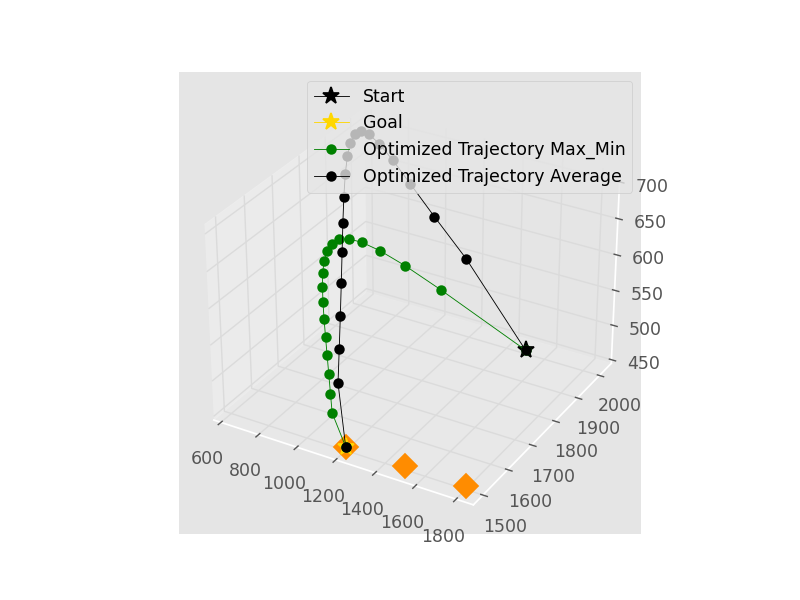

[[1500.      2000.       450.     ]
 [1092.15045 1963.81864  516.50018]
 [ 928.09227 1940.53013  546.05976]
 [ 821.55346 1919.82232  565.34039]
 [ 751.72707 1899.70187  577.86522]
 [ 707.82958 1879.30549  585.36054]
 [ 683.96473 1858.23163  588.76423]
 [ 676.37166 1836.27856  588.69501]
 [ 682.29067 1813.33947  585.64204]
 [ 699.45241 1789.35905  580.04465]
 [ 725.85045 1764.31718  572.32191]
 [ 759.65042 1738.2248   562.87868]
 [ 799.16545 1711.12489  552.10128]
 [ 842.86359 1683.09478  540.34874]
 [ 889.39257 1654.24765  527.94199]
 [ 937.61921 1624.7341   515.15029]
 [ 986.68211 1594.74667  502.17481]
 [1036.03268 1564.51757  489.138  ]
 [1085.42256 1534.24345  476.09264]
 [1200.      1500.       450.     ]]
[[1500.      2000.       450.     ]
 [1158.16103 2017.42848  550.88085]
 [ 991.50976 2014.03044  599.77804]
 [ 865.96704 2011.16482  638.11017]
 [ 777.18591 2006.87143  666.63475]
 [ 715.32032 1999.69197  686.97591]
 [ 674.92018 1988.83653  700.09955]
 [ 652.74294 1973.88499  70

In [31]:
tmp_traj = np.array([[1500., 2000., 450.],
                     [1092.15045, 1963.81864, 516.50018],
                     [928.09227, 1940.53013, 546.05976],
                     [821.55346, 1919.82232, 565.34039],
                     [751.72707, 1899.70187, 577.86522],
                     [707.82958, 1879.30549, 585.36054],
                     [683.96473, 1858.23163, 588.76423],
                     [676.37166, 1836.27856, 588.69501],
                     [682.29067, 1813.33947, 585.64204],
                     [699.45241, 1789.35905, 580.04465],
                     [725.85045, 1764.31718, 572.32191],
                     [759.65042, 1738.2248, 562.87868],
                     [799.16545, 1711.12489, 552.10128],
                     [842.86359, 1683.09478, 540.34874],
                     [889.39257, 1654.24765, 527.94199],
                     [937.61921, 1624.7341, 515.15029],
                     [986.68211, 1594.74667, 502.17481],
                     [1036.03268, 1564.51757, 489.138],
                     [1085.42256, 1534.24345, 476.09264],
                     [1200., 1500., 450.]])

fig1 = plt.figure('Trajectory World')
plt.clf()
ax = fig1.gca(projection='3d')
# ax.plot(np.array([user1_translation[0]]), np.array([user1_translation[1]]), np.array([user1_translation[2]]),
#         color='red', marker='2', markersize=15, label='User1')
# ax.plot(np.array([user2_translation[0]]), np.array([user2_translation[1]]), np.array([user2_translation[2]]),
#         color='green', marker='2', markersize=15, label='User2')
# ax.plot(np.array([user3_translation[0]]), np.array([user3_translation[1]]), np.array([user3_translation[2]]),
#         color='brown', marker='2', markersize=15, label='User3')
ax.plot(np.array([targets['A'][0]]), np.array([targets['A'][1]]), np.array([targets['A'][2]]),
        color='darkorange', marker='D', markersize=10)
ax.plot(np.array([targets['B'][0]]), np.array([targets['B'][1]]), np.array([targets['B'][2]]),
        color='darkorange', marker='D', markersize=10)
ax.plot(np.array([targets['C'][0]]), np.array([targets['C'][1]]), np.array([targets['C'][2]]),
        color='darkorange', marker='D', markersize=10)
# ax.plot(np.array([robot_translation[0]]), np.array([robot_translation[1]]), np.array([robot_translation[2]]),
#         color='blue', marker='o', markersize=10, label='Robot')
ax.plot(np.array([tmp_traj[0, 0]]), np.array([tmp_traj[0, 1]]), np.array([tmp_traj[0, 2]]),
        color='black', marker='*', markersize=10, label='Start')
ax.plot(np.array([tmp_traj[-1, 0]]), np.array([tmp_traj[-1, 1]]),
        np.array([tmp_traj[-1, 2]]),
        color='gold', marker='*', markersize=10, label='Goal')
ax.plot(tmp_traj[:, 0], tmp_traj[:, 1], tmp_traj[:, 2], 'green', markersize=10, marker='.',
        label='Optimized Trajectory Max_Min')
ax.plot(trajs[max(list(trajs.keys()))][:, 0], trajs[max(list(trajs.keys()))][:, 1], trajs[max(list(trajs.keys()))][:, 2], 
        'black', markersize=10, marker='.', label='Optimized Trajectory Average')
plt.legend(loc='best')
fig1.show()

print(tmp_traj)
print(trajs[max(list(trajs.keys()))])

<IPython.core.display.Javascript object>


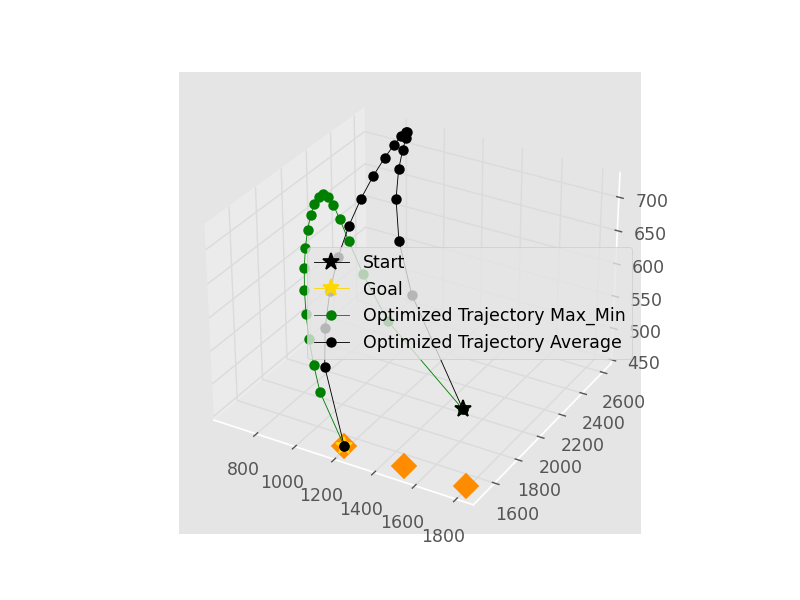

[[1500.      2000.0009   449.99722]
 [1103.76118 2020.81853  547.06033]
 [ 937.19503 2084.98078  595.14948]
 [ 831.89341 2138.31845  627.96261]
 [ 762.96017 2174.873    650.66153]
 [ 716.78651 2194.85277  665.87283]
 [ 686.40524 2199.08239  674.93397]
 [ 668.06414 2188.59357  678.62781]
 [ 659.80393 2164.53239  677.51133]
 [ 660.67121 2128.35012  672.03902]
 [ 670.28702 2081.78715  662.66943]
 [ 688.50279 2026.85991  649.88756]
 [ 715.18272 1965.73545  634.19205]
 [ 750.06904 1900.62358  616.0708 ]
 [ 792.72197 1833.61259  596.04062]
 [ 842.57802 1766.5695   574.484  ]
 [ 899.0473  1701.0173   551.7194 ]
 [ 961.70883 1638.15984  527.88527]
 [1030.29456 1578.90657  502.97298]
 [1199.99318 1500.00053  450.00559]]
[[1500.      2000.0009   449.99722]
 [1146.31831 2154.44982  570.9018 ]
 [1010.33062 2271.66232  624.10191]
 [ 926.20682 2387.09307  664.3803 ]
 [ 883.57865 2480.65179  692.77603]
 [ 865.07792 2547.34967  711.86984]
 [ 857.6414  2588.44384  723.69851]
 [ 853.19707 2606.36701  72

In [40]:
joint_trajectory_average = np.array([[-0., 0.9271, 0.71609, -0., 3.0692, 0.],
                                     [-0.39617, 0.75034, 0.86938, -0., 3.09266, 0.01538],
                                     [-0.5919, 0.66422, 0.9348, -0., 3.11337, 0.02999],
                                     [-0.75245, 0.59239, 0.99186, -0., -3.15505, 0.04387],
                                     [-0.87066, 0.5366, 1.03842, -0., -3.14582, 0.05708],
                                     [-0.95145, 0.49589, 1.07332, -0., -3.14001, 0.06965],
                                     [-1.00099, 0.46945, 1.09537, -0., -3.13561, 0.08164],
                                     [-1.02409, 0.45683, 1.10336, -0., -3.13099, 0.09306],
                                     [-1.02438, 0.45771, 1.09621, -0., -3.12472, 0.10397],
                                     [-1.00486, 0.47167, 1.07309, -0., -3.11555, 0.11439],
                                     [-0.96826, 0.49799, 1.03355, -0., -3.10234, 0.12435],
                                     [-0.91737, 0.53566, 0.97762, -0., -3.08408, 0.13389],
                                     [-0.855, 0.5834, 0.90581, -0., -3.06001, 0.14302],
                                     [-0.78387, 0.63974, 0.81916, -0., -3.02969, 0.15177],
                                     [-0.70651, 0.7031, 0.71929, -0., -2.99319, 0.16015],
                                     [-0.62519, 0.77188, 0.60849, -0., -2.95116, 0.16821],
                                     [-0.5418, 0.84442, 0.48978, -0., -2.905, 0.17594],
                                     [-0.45768, 0.91922, 0.36658, -0., -2.8566, 0.18337],
                                     [-0.37333, 0.99521, 0.2415, -0., -2.80751, 0.19052],
                                     [-0.1974, 1.13158, 0.03295, 0., -2.73533, 0.1974]])

joint_trajectory_maxmin = np.array([[-0., 0.9271, 0.71609, -0., 3.0692, 0.],
                                     [-0.38452, 0.81627, 0.70156, -0., 3.19456, 0.01538],
                                     [-0.55143, 0.76268, 0.7001, -0., 3.2496, 0.02999],
                                     [-0.65953, 0.729, 0.69251, -0., -2.9923, 0.04387],
                                     [-0.72907, 0.70877, 0.68036, -0., -2.95992, 0.05708],
                                     [-0.77159, 0.69872, 0.66423, -0., -2.93374, 0.06965],
                                     [-0.79325, 0.69723, 0.64409, -0., -2.91212, 0.08164],
                                     [-0.79789, 0.70333, 0.61977, -0., -2.89389, 0.09306],
                                     [-0.78822, 0.71629, 0.59107, -0., -2.87816, 0.10397],
                                     [-0.76651, 0.73542, 0.55793, -0., -2.86415, 0.11439],
                                     [-0.73481, 0.75997, 0.52044, -0., -2.8512, 0.12435],
                                     [-0.69507, 0.78913, 0.47884, -0., -2.83876, 0.13389],
                                     [-0.64912, 0.82208, 0.43348, -0., -2.82636, 0.14302],
                                     [-0.59864, 0.85803, 0.38481, -0., -2.81363, 0.15177],
                                     [-0.5451, 0.89622, 0.33331, -0., -2.80033, 0.16015],
                                     [-0.4897, 0.93606, 0.27948, -0., -2.78633, 0.16821],
                                     [-0.43331, 0.97709, 0.22375, -0., -2.77163, 0.17594],
                                     [-0.37642, 1.01904, 0.16652, -0., -2.75636, 0.18337],
                                     [-0.31922, 1.06183, 0.10804, -0., -2.74067, 0.19052],
                                     [-0.1974, 1.13158, 0.03295, 0., -2.73533, 0.1974]])

world_traj_joint_average = transform_world(forward_kinematics_irb4600(robot_model, joint_trajectory_average), robot_pose)
world_traj_joint_maxmin = transform_world(forward_kinematics_irb4600(robot_model, joint_trajectory_maxmin), robot_pose)

fig1 = plt.figure('Trajectory Joints')
plt.clf()
ax = fig1.gca(projection='3d')
# ax.plot(np.array([user1_translation[0]]), np.array([user1_translation[1]]), np.array([user1_translation[2]]),
#         color='red', marker='2', markersize=15, label='User1')
# ax.plot(np.array([user2_translation[0]]), np.array([user2_translation[1]]), np.array([user2_translation[2]]),
#         color='green', marker='2', markersize=15, label='User2')
# ax.plot(np.array([user3_translation[0]]), np.array([user3_translation[1]]), np.array([user3_translation[2]]),
#         color='brown', marker='2', markersize=15, label='User3')
ax.plot(np.array([targets['A'][0]]), np.array([targets['A'][1]]), np.array([targets['A'][2]]),
        color='darkorange', marker='D', markersize=10)
ax.plot(np.array([targets['B'][0]]), np.array([targets['B'][1]]), np.array([targets['B'][2]]),
        color='darkorange', marker='D', markersize=10)
ax.plot(np.array([targets['C'][0]]), np.array([targets['C'][1]]), np.array([targets['C'][2]]),
        color='darkorange', marker='D', markersize=10)
# ax.plot(np.array([robot_translation[0]]), np.array([robot_translation[1]]), np.array([robot_translation[2]]),
#         color='blue', marker='o', markersize=10, label='Robot')
ax.plot(np.array([world_traj_joint_maxmin[0, 0]]), np.array([world_traj_joint_maxmin[0, 1]]), np.array([world_traj_joint_maxmin[0, 2]]),
        color='black', marker='*', markersize=10, label='Start')
ax.plot(np.array([tmp_traj[-1, 0]]), np.array([tmp_traj[-1, 1]]),
        np.array([tmp_traj[-1, 2]]),
        color='gold', marker='*', markersize=10, label='Goal')
ax.plot(world_traj_joint_maxmin[:, 0], world_traj_joint_maxmin[:, 1], world_traj_joint_maxmin[:, 2], 
        'green', markersize=10, marker='.', label='Optimized Trajectory Max_Min')
ax.plot(world_traj_joint_average[:, 0], world_traj_joint_average[:, 1], world_traj_joint_average[:, 2], 
        'black', markersize=10, marker='.', label='Optimized Trajectory Average')
plt.legend(loc='best')
fig1.show()

print(world_traj_joint_maxmin)
print(world_traj_joint_average)

<IPython.core.display.Javascript object>


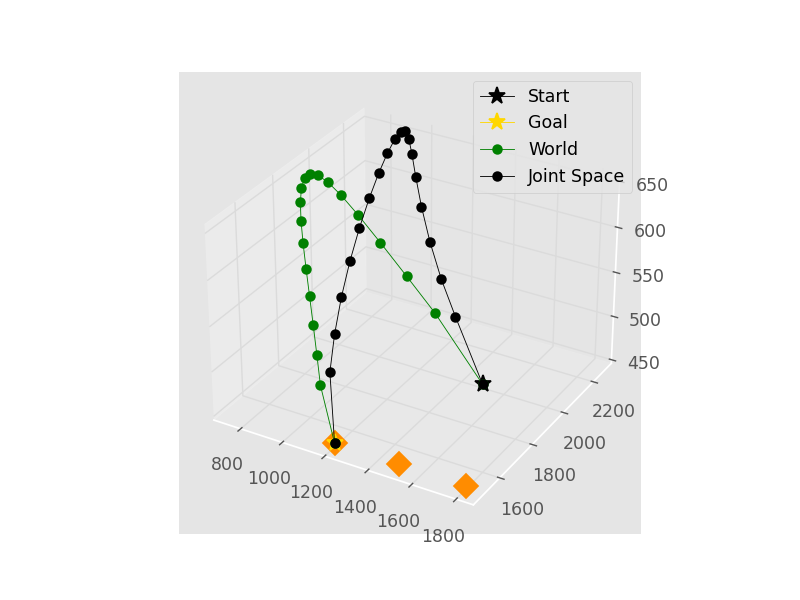

[[1500.      2000.       450.     ]
 [1268.92047 2002.34913  514.84401]
 [1142.61681 1990.80942  549.54787]
 [1026.79296 1979.60813  581.13201]
 [ 932.18546 1968.42159  606.82364]
 [ 860.6514  1956.40021  626.07081]
 [ 808.87236 1942.68557  639.36064]
 [ 773.84185 1926.66343  647.16879]
 [ 753.47035 1907.92865  649.88564]
 [ 746.45459 1886.2376   647.86977]
 [ 752.09899 1861.47358  641.48667]
 [ 769.74579 1833.61458  631.13568]
 [ 798.14082 1802.71276  617.27508]
 [ 835.3403  1768.89734  600.44196]
 [ 879.05735 1732.39371  581.24927]
 [ 927.01814 1693.54502  560.36052]
 [ 977.23648 1652.81746  538.44463]
 [1028.34743 1610.71697  516.09865]
 [1079.88596 1567.45716  493.76666]
 [1200.      1500.       450.     ]]
[[1500.      2000.       450.     ]
 [1333.55141 2045.16331  508.11676]
 [1243.33317 2073.54944  539.70203]
 [1158.38067 2111.87841  570.22797]
 [1082.95327 2155.97927  597.87201]
 [1020.71679 2199.63944  620.95648]
 [ 973.19677 2236.04714  638.36522]
 [ 939.22346 2259.84332  64

In [56]:
joint_traj_avg = joint_avg_trajs[max(list(joint_avg_trajs.keys()))]
world_traj_avg = world_avg_traj[max(list(world_avg_traj.keys()))]

world_traj_joint_average = transform_world(forward_kinematics_irb4600(robot_model, joint_traj_avg), robot_pose)

fig1 = plt.figure('Trajectory Average')
plt.clf()
ax = fig1.gca(projection='3d')
# ax.plot(np.array([user1_translation[0]]), np.array([user1_translation[1]]), np.array([user1_translation[2]]),
#         color='red', marker='2', markersize=15, label='User1')
# ax.plot(np.array([user2_translation[0]]), np.array([user2_translation[1]]), np.array([user2_translation[2]]),
#         color='green', marker='2', markersize=15, label='User2')
# ax.plot(np.array([user3_translation[0]]), np.array([user3_translation[1]]), np.array([user3_translation[2]]),
#         color='brown', marker='2', markersize=15, label='User3')
ax.plot(np.array([targets['A'][0]]), np.array([targets['A'][1]]), np.array([targets['A'][2]]),
        color='darkorange', marker='D', markersize=10)
ax.plot(np.array([targets['B'][0]]), np.array([targets['B'][1]]), np.array([targets['B'][2]]),
        color='darkorange', marker='D', markersize=10)
ax.plot(np.array([targets['C'][0]]), np.array([targets['C'][1]]), np.array([targets['C'][2]]),
        color='darkorange', marker='D', markersize=10)
# ax.plot(np.array([robot_translation[0]]), np.array([robot_translation[1]]), np.array([robot_translation[2]]),
#         color='blue', marker='o', markersize=10, label='Robot')
ax.plot(np.array([world_traj_avg[0, 0]]), np.array([world_traj_avg[0, 1]]), np.array([world_traj_avg[0, 2]]),
        color='black', marker='*', markersize=10, label='Start')
ax.plot(np.array([world_traj_avg[-1, 0]]), np.array([world_traj_avg[-1, 1]]), np.array([world_traj_avg[-1, 2]]),
        color='gold', marker='*', markersize=10, label='Goal')
ax.plot(world_traj_avg[:, 0], world_traj_avg[:, 1], world_traj_avg[:, 2], 
        'green', markersize=10, marker='.', label='World')
ax.plot(world_traj_joint_average[:, 0], world_traj_joint_average[:, 1], world_traj_joint_average[:, 2], 
        'black', markersize=10, marker='.', label='Joint Space')
plt.legend(loc='best')
fig1.show()

print(world_traj_avg)
print(world_traj_joint_average)

<IPython.core.display.Javascript object>


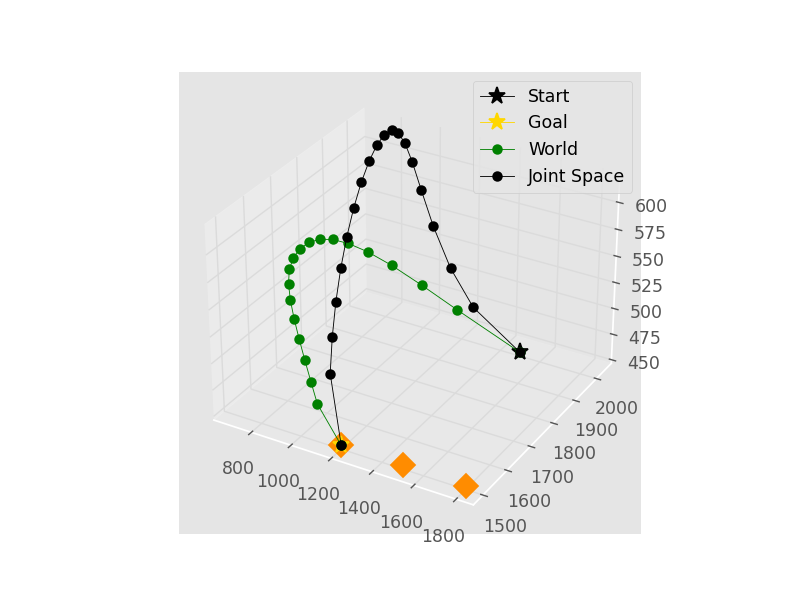

[[1500.      2000.       450.     ]
 [1231.11303 1950.25337  487.20354]
 [1090.17134 1916.9393   509.87424]
 [ 974.05596 1887.05018  528.37704]
 [ 885.39387 1859.7438   541.8878 ]
 [ 818.96835 1834.19407  551.18521]
 [ 769.91142 1809.81763  556.96923]
 [ 734.39262 1786.19936  559.73809]
 [ 709.53852 1763.03436  559.84165]
 [ 693.99405 1740.09846  557.54574]
 [ 688.91431 1717.22761  553.13633]
 [ 697.88423 1694.29215  546.99432]
 [ 723.19244 1671.16621  539.44001]
 [ 762.5227  1647.7235   530.62282]
 [ 811.64479 1623.86978  520.721  ]
 [ 867.10372 1599.57069  509.98526]
 [ 926.59087 1574.86815  498.65551]
 [ 988.67363 1549.88419  486.90921]
 [1052.53372 1524.73836  474.8564 ]
 [1200.      1500.       450.     ]]
[[1500.      2000.       450.     ]
 [1302.22293 1960.97443  491.18308]
 [1183.39237 1962.60734  522.29888]
 [1073.35945 1980.77414  553.20984]
 [ 983.22836 2003.90784  579.23099]
 [ 915.47037 2022.49845  598.7765 ]
 [ 866.51277 2032.38699  612.25101]
 [ 832.35913 2032.26227  62

In [57]:
joint_traj_maxmin = joint_trajs_maxmin[max(list(joint_trajs_maxmin.keys()))]
world_traj_maxmin = world_maxmin_trajs[max(list(world_maxmin_trajs.keys()))]

world_traj_joint_maxmin = transform_world(forward_kinematics_irb4600(robot_model, joint_traj_maxmin), robot_pose)

fig1 = plt.figure('Trajectory MaxMin')
plt.clf()
ax = fig1.gca(projection='3d')
# ax.plot(np.array([user1_translation[0]]), np.array([user1_translation[1]]), np.array([user1_translation[2]]),
#         color='red', marker='2', markersize=15, label='User1')
# ax.plot(np.array([user2_translation[0]]), np.array([user2_translation[1]]), np.array([user2_translation[2]]),
#         color='green', marker='2', markersize=15, label='User2')
# ax.plot(np.array([user3_translation[0]]), np.array([user3_translation[1]]), np.array([user3_translation[2]]),
#         color='brown', marker='2', markersize=15, label='User3')
ax.plot(np.array([targets['A'][0]]), np.array([targets['A'][1]]), np.array([targets['A'][2]]),
        color='darkorange', marker='D', markersize=10)
ax.plot(np.array([targets['B'][0]]), np.array([targets['B'][1]]), np.array([targets['B'][2]]),
        color='darkorange', marker='D', markersize=10)
ax.plot(np.array([targets['C'][0]]), np.array([targets['C'][1]]), np.array([targets['C'][2]]),
        color='darkorange', marker='D', markersize=10)
# ax.plot(np.array([robot_translation[0]]), np.array([robot_translation[1]]), np.array([robot_translation[2]]),
#         color='blue', marker='o', markersize=10, label='Robot')
ax.plot(np.array([world_traj_maxmin[0, 0]]), np.array([world_traj_maxmin[0, 1]]), np.array([world_traj_maxmin[0, 2]]),
        color='black', marker='*', markersize=10, label='Start')
ax.plot(np.array([world_traj_maxmin[-1, 0]]), np.array([world_traj_maxmin[-1, 1]]), np.array([world_traj_maxmin[-1, 2]]),
        color='gold', marker='*', markersize=10, label='Goal')
ax.plot(world_traj_maxmin[:, 0], world_traj_maxmin[:, 1], world_traj_maxmin[:, 2], 
        'green', markersize=10, marker='.', label='World')
ax.plot(world_traj_joint_maxmin[:, 0], world_traj_joint_maxmin[:, 1], world_traj_joint_maxmin[:, 2], 
        'black', markersize=10, marker='.', label='Joint Space')
plt.legend(loc='best')
fig1.show()

print(world_traj_maxmin)
print(world_traj_joint_maxmin)

<IPython.core.display.Javascript object>


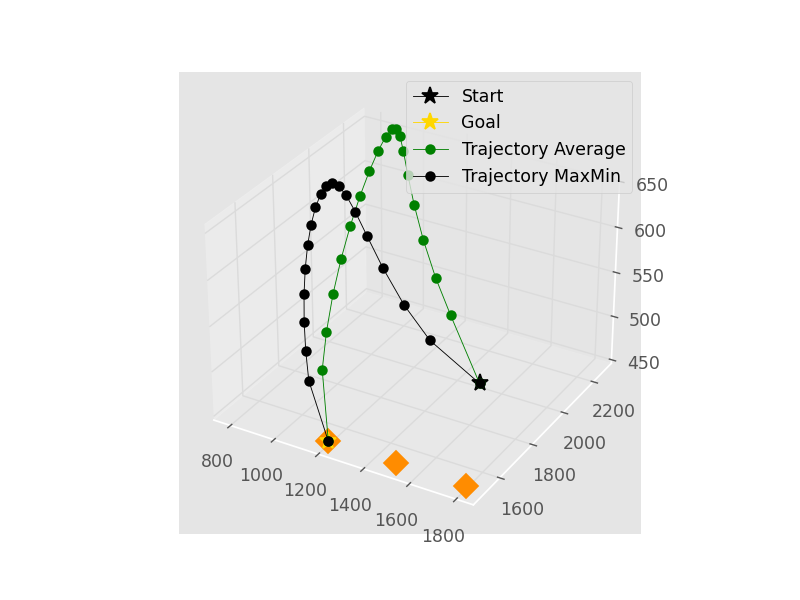

[[1500.      2000.       450.     ]
 [1333.55141 2045.16331  508.11676]
 [1243.33317 2073.54944  539.70203]
 [1158.38067 2111.87841  570.22797]
 [1082.95327 2155.97927  597.87201]
 [1020.71679 2199.63944  620.95648]
 [ 973.19677 2236.04714  638.36522]
 [ 939.22346 2259.84332  649.72905]
 [ 916.09815 2267.96962  655.1863 ]
 [ 901.13292 2259.27419  655.08764]
 [ 892.49752 2233.86637  649.85682]
 [ 889.38698 2192.68834  639.96781]
 [ 891.83597 2137.28376  625.96202]
 [ 900.41344 2069.66527  608.46436]
 [ 915.91749 1992.24125  588.18286]
 [ 939.12393 1907.79481  565.88138]
 [ 970.62845 1819.46314  542.30534]
 [1010.83131 1730.50678  518.07376]
 [1060.00247 1643.42778  493.74179]
 [1200.      1500.       450.     ]]
[[1500.      2000.       450.     ]
 [1302.22293 1960.97443  491.18308]
 [1183.39237 1962.60734  522.29888]
 [1073.35945 1980.77414  553.20984]
 [ 983.22836 2003.90784  579.23099]
 [ 915.47037 2022.49845  598.7765 ]
 [ 866.51277 2032.38699  612.25101]
 [ 832.35913 2032.26227  62

In [53]:
joint_traj_avg = joint_avg_trajs[max(list(joint_avg_trajs.keys()))]
joint_traj_maxmin = joint_trajs_maxmin[max(list(joint_trajs_maxmin.keys()))]
world_traj_joint_average = transform_world(forward_kinematics_irb4600(robot_model, joint_traj_avg), robot_pose)
world_traj_joint_maxmin = transform_world(forward_kinematics_irb4600(robot_model, joint_traj_maxmin), robot_pose)

fig1 = plt.figure('Trajectory Joint')
plt.clf()
ax = fig1.gca(projection='3d')
# ax.plot(np.array([user1_translation[0]]), np.array([user1_translation[1]]), np.array([user1_translation[2]]),
#         color='red', marker='2', markersize=15, label='User1')
# ax.plot(np.array([user2_translation[0]]), np.array([user2_translation[1]]), np.array([user2_translation[2]]),
#         color='green', marker='2', markersize=15, label='User2')
# ax.plot(np.array([user3_translation[0]]), np.array([user3_translation[1]]), np.array([user3_translation[2]]),
#         color='brown', marker='2', markersize=15, label='User3')
ax.plot(np.array([targets['A'][0]]), np.array([targets['A'][1]]), np.array([targets['A'][2]]),
        color='darkorange', marker='D', markersize=10)
ax.plot(np.array([targets['B'][0]]), np.array([targets['B'][1]]), np.array([targets['B'][2]]),
        color='darkorange', marker='D', markersize=10)
ax.plot(np.array([targets['C'][0]]), np.array([targets['C'][1]]), np.array([targets['C'][2]]),
        color='darkorange', marker='D', markersize=10)
# ax.plot(np.array([robot_translation[0]]), np.array([robot_translation[1]]), np.array([robot_translation[2]]),
#         color='blue', marker='o', markersize=10, label='Robot')
ax.plot(np.array([world_traj_maxmin[0, 0]]), np.array([world_traj_maxmin[0, 1]]), np.array([world_traj_maxmin[0, 2]]),
        color='black', marker='*', markersize=10, label='Start')
ax.plot(np.array([world_traj_maxmin[-1, 0]]), np.array([world_traj_maxmin[-1, 1]]), np.array([world_traj_maxmin[-1, 2]]),
        color='gold', marker='*', markersize=10, label='Goal')
ax.plot(world_traj_joint_average[:, 0], world_traj_joint_average[:, 1], world_traj_joint_average[:, 2], 
        'green', markersize=10, marker='.', label='Trajectory Average')
ax.plot(world_traj_joint_maxmin[:, 0], world_traj_joint_maxmin[:, 1], world_traj_joint_maxmin[:, 2], 
        'black', markersize=10, marker='.', label='Trajectory MaxMin')
plt.legend(loc='best')
fig1.show()

print(world_traj_joint_average)
print(world_traj_joint_maxmin)

<IPython.core.display.Javascript object>


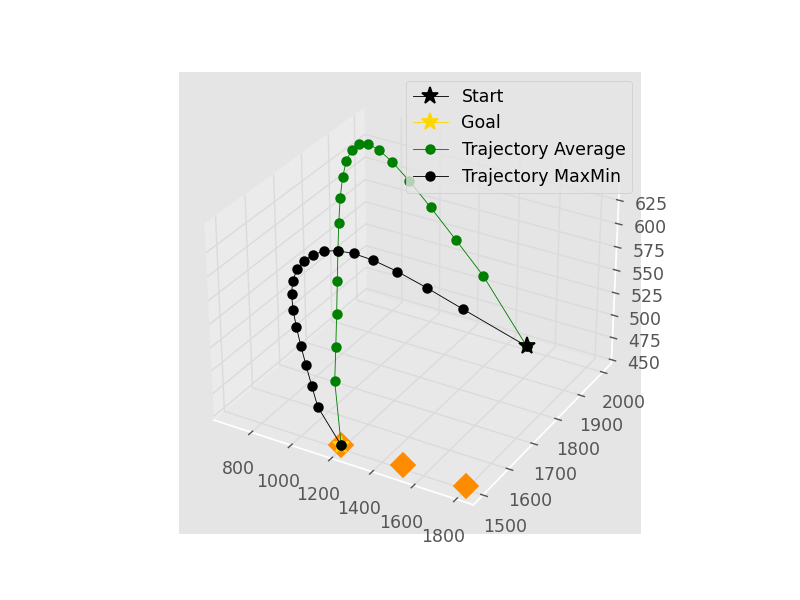

[[1500.      2000.       450.     ]
 [1268.92047 2002.34913  514.84401]
 [1142.61681 1990.80942  549.54787]
 [1026.79296 1979.60813  581.13201]
 [ 932.18546 1968.42159  606.82364]
 [ 860.6514  1956.40021  626.07081]
 [ 808.87236 1942.68557  639.36064]
 [ 773.84185 1926.66343  647.16879]
 [ 753.47035 1907.92865  649.88564]
 [ 746.45459 1886.2376   647.86977]
 [ 752.09899 1861.47358  641.48667]
 [ 769.74579 1833.61458  631.13568]
 [ 798.14082 1802.71276  617.27508]
 [ 835.3403  1768.89734  600.44196]
 [ 879.05735 1732.39371  581.24927]
 [ 927.01814 1693.54502  560.36052]
 [ 977.23648 1652.81746  538.44463]
 [1028.34743 1610.71697  516.09865]
 [1079.88596 1567.45716  493.76666]
 [1200.      1500.       450.     ]]
[[1500.      2000.       450.     ]
 [1231.11303 1950.25337  487.20354]
 [1090.17134 1916.9393   509.87424]
 [ 974.05596 1887.05018  528.37704]
 [ 885.39387 1859.7438   541.8878 ]
 [ 818.96835 1834.19407  551.18521]
 [ 769.91142 1809.81763  556.96923]
 [ 734.39262 1786.19936  55

In [54]:
world_traj_avg = world_avg_traj[max(list(world_avg_traj.keys()))]
world_traj_maxmin = world_maxmin_trajs[max(list(world_maxmin_trajs.keys()))]

fig1 = plt.figure('Trajectory World')
plt.clf()
ax = fig1.gca(projection='3d')
# ax.plot(np.array([user1_translation[0]]), np.array([user1_translation[1]]), np.array([user1_translation[2]]),
#         color='red', marker='2', markersize=15, label='User1')
# ax.plot(np.array([user2_translation[0]]), np.array([user2_translation[1]]), np.array([user2_translation[2]]),
#         color='green', marker='2', markersize=15, label='User2')
# ax.plot(np.array([user3_translation[0]]), np.array([user3_translation[1]]), np.array([user3_translation[2]]),
#         color='brown', marker='2', markersize=15, label='User3')
ax.plot(np.array([targets['A'][0]]), np.array([targets['A'][1]]), np.array([targets['A'][2]]),
        color='darkorange', marker='D', markersize=10)
ax.plot(np.array([targets['B'][0]]), np.array([targets['B'][1]]), np.array([targets['B'][2]]),
        color='darkorange', marker='D', markersize=10)
ax.plot(np.array([targets['C'][0]]), np.array([targets['C'][1]]), np.array([targets['C'][2]]),
        color='darkorange', marker='D', markersize=10)
# ax.plot(np.array([robot_translation[0]]), np.array([robot_translation[1]]), np.array([robot_translation[2]]),
#         color='blue', marker='o', markersize=10, label='Robot')
ax.plot(np.array([world_traj_maxmin[0, 0]]), np.array([world_traj_maxmin[0, 1]]), np.array([world_traj_maxmin[0, 2]]),
        color='black', marker='*', markersize=10, label='Start')
ax.plot(np.array([world_traj_maxmin[-1, 0]]), np.array([world_traj_maxmin[-1, 1]]), np.array([world_traj_maxmin[-1, 2]]),
        color='gold', marker='*', markersize=10, label='Goal')
ax.plot(world_traj_avg[:, 0], world_traj_avg[:, 1], world_traj_avg[:, 2], 
        'green', markersize=10, marker='.', label='Trajectory Average')
ax.plot(world_traj_maxmin[:, 0], world_traj_maxmin[:, 1], world_traj_maxmin[:, 2], 
        'black', markersize=10, marker='.', label='Trajectory MaxMin')
plt.legend(loc='best')
fig1.show()

print(world_traj_avg)
print(world_traj_maxmin)